# LSTM timeseries forecasting with Keras Tuner
> A example of using an LSTM network to forecast timeseries, using Keras Tuner for hyperparameters tuning.

- toc: true 
- badges: true
- comments: true
- categories: [lstm, keras, keras tuner, python, machine learning, timeseries]
- image: images/2021-05-31-LSTM timeseries forecasting with Keras Tuner-MAIN.jpg

# About

This project is a demonstration of some of capabilities of [Keras Tuner](https://github.com/keras-team/keras-tuner). This project is an attempt to use an `LSTM` based neural network (RNN) to forecast `timeseries` data.

## The required libraries

Import the `must-have` libraries:

In [30]:
import numpy as np
import pandas as pd
import datetime as dt
from IPython import display as ids

Import the elements required from the `scikit-learn` library:

In [2]:
import sklearn as sk
import sklearn.preprocessing as skp
import sklearn.model_selection as skms
import sklearn.pipeline as skpl
import sklearn.decomposition as skd
import sklearn.linear_model as sklm
import sklearn.dummy as sky
import sklearn.metrics as skme

Enables defining partial functions:

In [3]:
from functools import partial

Import the `keras` elements from the `tensorflow` library:

In [4]:
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import backend as kb
from tensorflow.keras import callbacks as kc
from tensorflow.keras import models as km
from tensorflow.keras import layers as kl
from tensorflow.keras import regularizers as kr
from tensorflow.keras import optimizers as ko
from tensorflow.keras import utils as ku

Import the `keras-tuner` library as we'll use it to tune `hyperparameters`:

In [5]:
import kerastuner as kt
from kerastuner import tuners as ktt
from kerastuner import engine as kte

Import `matplotlib` and set the default magic:

In [6]:
import matplotlib as mat
from matplotlib import pyplot as plt
import pylab as pyl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Import the `mlviz` library used to plot `time-series` visualizations:

In [7]:
from mlviz.timeseries import visualizationhelpers as mwvh
from mlviz.utilities import graphichelpers as mwgh

## The project parameters

Reset the predefined `matplotlib` style:

In [8]:
mwgh.GraphicsStatics.initialize_matplotlib_styles()

Here is the **color palette** we'll use for the project:

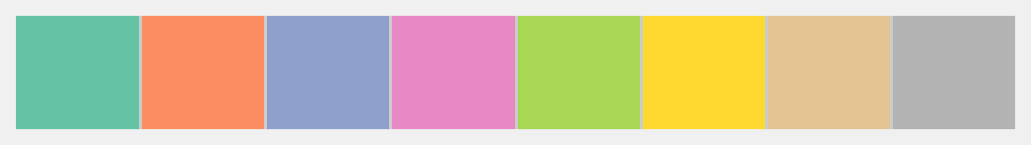

In [9]:
sns.palplot(mwgh.GraphicsStatics.g_palette)

Let's capture all the usefull project's **parameters** in a dictionary:

In [10]:
params = {}

params['project_date'] = '2021-05-31'
params['project_name'] = 'LSTM+01'
params['experiment_timestamp'] = str(int(1000 * dt.datetime.timestamp(dt.datetime.utcnow())))

params['experiment_name'] = '{0}-{1}-{2}'.format(
    params['project_date'], 
    params['experiment_timestamp'],
    params['project_name'])

params['data_frequency'] = 'W-SAT'
params['features'] = ['y']

params['input_size'] = 52          # N weeks of data to input into the network
params['output_size'] = 13         # N weeks of data to output from the network
params['testing_size'] = 52        # N weeks of data to keep for testing the model
params['lag_size'] = [13, 26, 39]  # Lagged data series injected into the network

params['hyperband_iterations'] = 3
params['max_epochs'] = 250
params['patience'] = params['max_epochs'] / 10 
params['batch_size'] = 32

## The timeseries data

The input data is available in a `csv` file named `timeseries-data.csv` located in the `data` folder. It has got 2 columns `date` containing the date of event and `value` holding the value of the source. We'll rename these 2 columns as `ds` and `y` for convenience. Let's load the `csv` file using the `pandas` library and have a look at the data.

In [11]:
df = pd.read_csv(
    filepath_or_buffer='../assets/data/timeseries-data.csv',
    sep=';')

df.rename(
    columns = {
        'date': 'index',
        'value': 'y'
    }, 
    inplace=True)

df['index'] = pd.to_datetime(
    arg=df['index'], 
    dayfirst=True)

df.sort_values(
    by='index', 
    ascending=True,
    inplace=True)

df.set_index(
    keys='index', 
    inplace=True)

df = df.asfreq(
    freq=params['data_frequency'])

df['ds'] = df.index

print('df.shape = {0}'.format(df.shape))

df.tail(5)

df.shape = (625, 2)


,y,ds
index,,
2019-09-28,5547,2019-09-28
2019-10-05,6459,2019-10-05
2019-10-12,5838,2019-10-12
2019-10-19,5894,2019-10-19
2019-10-26,7925,2019-10-26


### Prepare data for the network

It is time to prepare the dataset to feed into the **LSTM** model. We'll use 4 features as input: the current data point as well as 3 additional data points from respectively 13, 26 and 39 weeks before the current datapoint the **lag** features below). 

![](./images/lstm-data.jpg)

It's easy to calculate the **width** of a sample:

In [12]:
sample_width = max(params['lag_size']) + params['input_size'] + params['output_size']
print('sample_width: {0}'.format(sample_width))

sample_width: 104


To avoid any overlap between the `training` and the `testing` data set, we'll first split the dataframes, keeping `params['testing_size']` samples for testing our model. We need to make sure that no data point used for training is also used for testing our model.

In [13]:
threshold_date = pd.to_datetime(df.index[df.shape[0] - (sample_width + params['testing_size'])])
print('Cutoff date for training/testing split is {0}'.format(threshold_date.strftime('%d/%m/%Y')))

Cutoff date for training/testing split is 05/11/2016


Let's cut the dataframe at the right date:

In [14]:
test_mask = (df['ds'] > threshold_date)
df_train = df[~test_mask]
df_test = df[test_mask]
print('df_train.shape = {0}'.format(df_train.shape))
print('df_test.shape = {0}'.format(df_test.shape))

df_train.shape = (470, 2)
df_test.shape = (155, 2)


The `prepare_data` funtion will take care of doing exactly this:

In [15]:
def prepare_data(data, lag_data, cols_in, steps_in, cols_out, steps_out, scaler_in=None, scaler_out=None):
    
    df = data.copy()
    cols_in_original = [col for col in cols_in]
    cols_in_processed = [col for col in cols_in]
    
    steps_lag = 0
    
    if lag_data is not None and len(lag_data) > 0:
        steps_lag = max(lag_data)
        
        for col in cols_in_original:
            for i, lag in enumerate(lag_data):
                lag_col = '{0}_{1}'.format(col, lag)
                df[lag_col] = df[col].shift(lag)
                cols_in_processed.append(lag_col)
        
    samples = df.shape[0] - (steps_in + steps_out + steps_lag) + 1
    
    if samples < 1:
        raise ValueError('not enough data to produce 1 sample.')
    
    index = list(df.index)
    cols_in_indices = {name: i for i, name in enumerate(cols_in_processed)}
    cols_out_indices = {name: i for i, name in enumerate(cols_out)}
    
    df.reset_index(inplace=True)
    
    
    X_input_scaled = None
    
    if scaler_in is None:
        scaler_in = skpl.Pipeline([
            ('std', skp.StandardScaler()),
            ('minmax', skp.MinMaxScaler(feature_range=(-1, 1)))])

        X_input_scaled = scaler_in.fit_transform(df[cols_in_processed].values)
    else:
        X_input_scaled = scaler_in.transform(df[cols_in_processed].values)
    
    
    y_output_scaled = None
    
    if scaler_out is None:
        scaler_out = skpl.Pipeline([
            ('std', skp.StandardScaler()),
            ('minmax', skp.MinMaxScaler(feature_range=(-1, 1)))])

        y_output_scaled = scaler_out.fit_transform(df[cols_out].values)
    else:
        y_output_scaled = scaler_out.transform(df[cols_out].values)
        
        
    X = []
    y = []
    
    for sample in range(samples):
        for step_in in range(steps_in):
            for col_in in range(len(cols_in_processed)):
                X.append(X_input_scaled[sample+steps_lag+step_in, col_in])
        for step_out in range(steps_out):
            for col_out in range(len(cols_out)):
                y.append(y_output_scaled[sample+steps_lag+steps_in+step_out, col_out])
    
    X = np.array(X).reshape(samples, steps_in, len(cols_in_processed))
    y = np.array(y).reshape(samples, steps_out, len(cols_out))
    
    return X, y, index, scaler_in, scaler_out, cols_in_indices, cols_out_indices

Every intput feature (passed via the function parameter `cols_in`) is going to be rescalled using a `scikit-learn` pipeline containing first a `StandardScaler` and then a `MinMaxScaler` in order to end up with a feature range of `[-1, +1]` required by neural networks.

In [16]:
X_train, y_train, index_train, scaler_in, scaler_out, cols_in_indices_train, cols_out_indices_train = prepare_data(
    data=df_train,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'])

print('X_train.shape: {0}'.format(X_train.shape))
print('y_train.shape: {0}'.format(y_train.shape))

X_train.shape: (367, 52, 4)
y_train.shape: (367, 13, 1)


To prepare the `testing` data, we need to reuse both **input** (variable `scaler_in`) and **output** (variable `scaler_out`) pipelines in order to keep data scaled in the same way.

In [17]:
X_test, y_test, index_test, _, _, cols_in_indices_test, cols_out_indices_test = prepare_data(
    data=df_test,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'],
    scaler_in=scaler_in, 
    scaler_out=scaler_out)

print('X_test.shape: {0}'.format(X_test.shape))
print('y_test.shape: {0}'.format(y_test.shape))

X_test.shape: (52, 52, 4)
y_test.shape: (52, 13, 1)


Let's compute the entire dataset and keep the output data for visualization:

In [18]:
X, y, index, _, _, cols_in_indices, cols_out_indices = prepare_data(
    data=df,
    lag_data=params['lag_size'],
    cols_in=params['features'],
    steps_in=params['input_size'],
    cols_out=params['features'],
    steps_out=params['output_size'],
    scaler_in=scaler_in, 
    scaler_out=scaler_out)

print('X.shape: {0}'.format(X.shape))
print('y.shape: {0}'.format(y.shape))

X.shape: (522, 52, 4)
y.shape: (522, 13, 1)


### Data visualization

Let's have a look at the visual representation of the timeseries data:

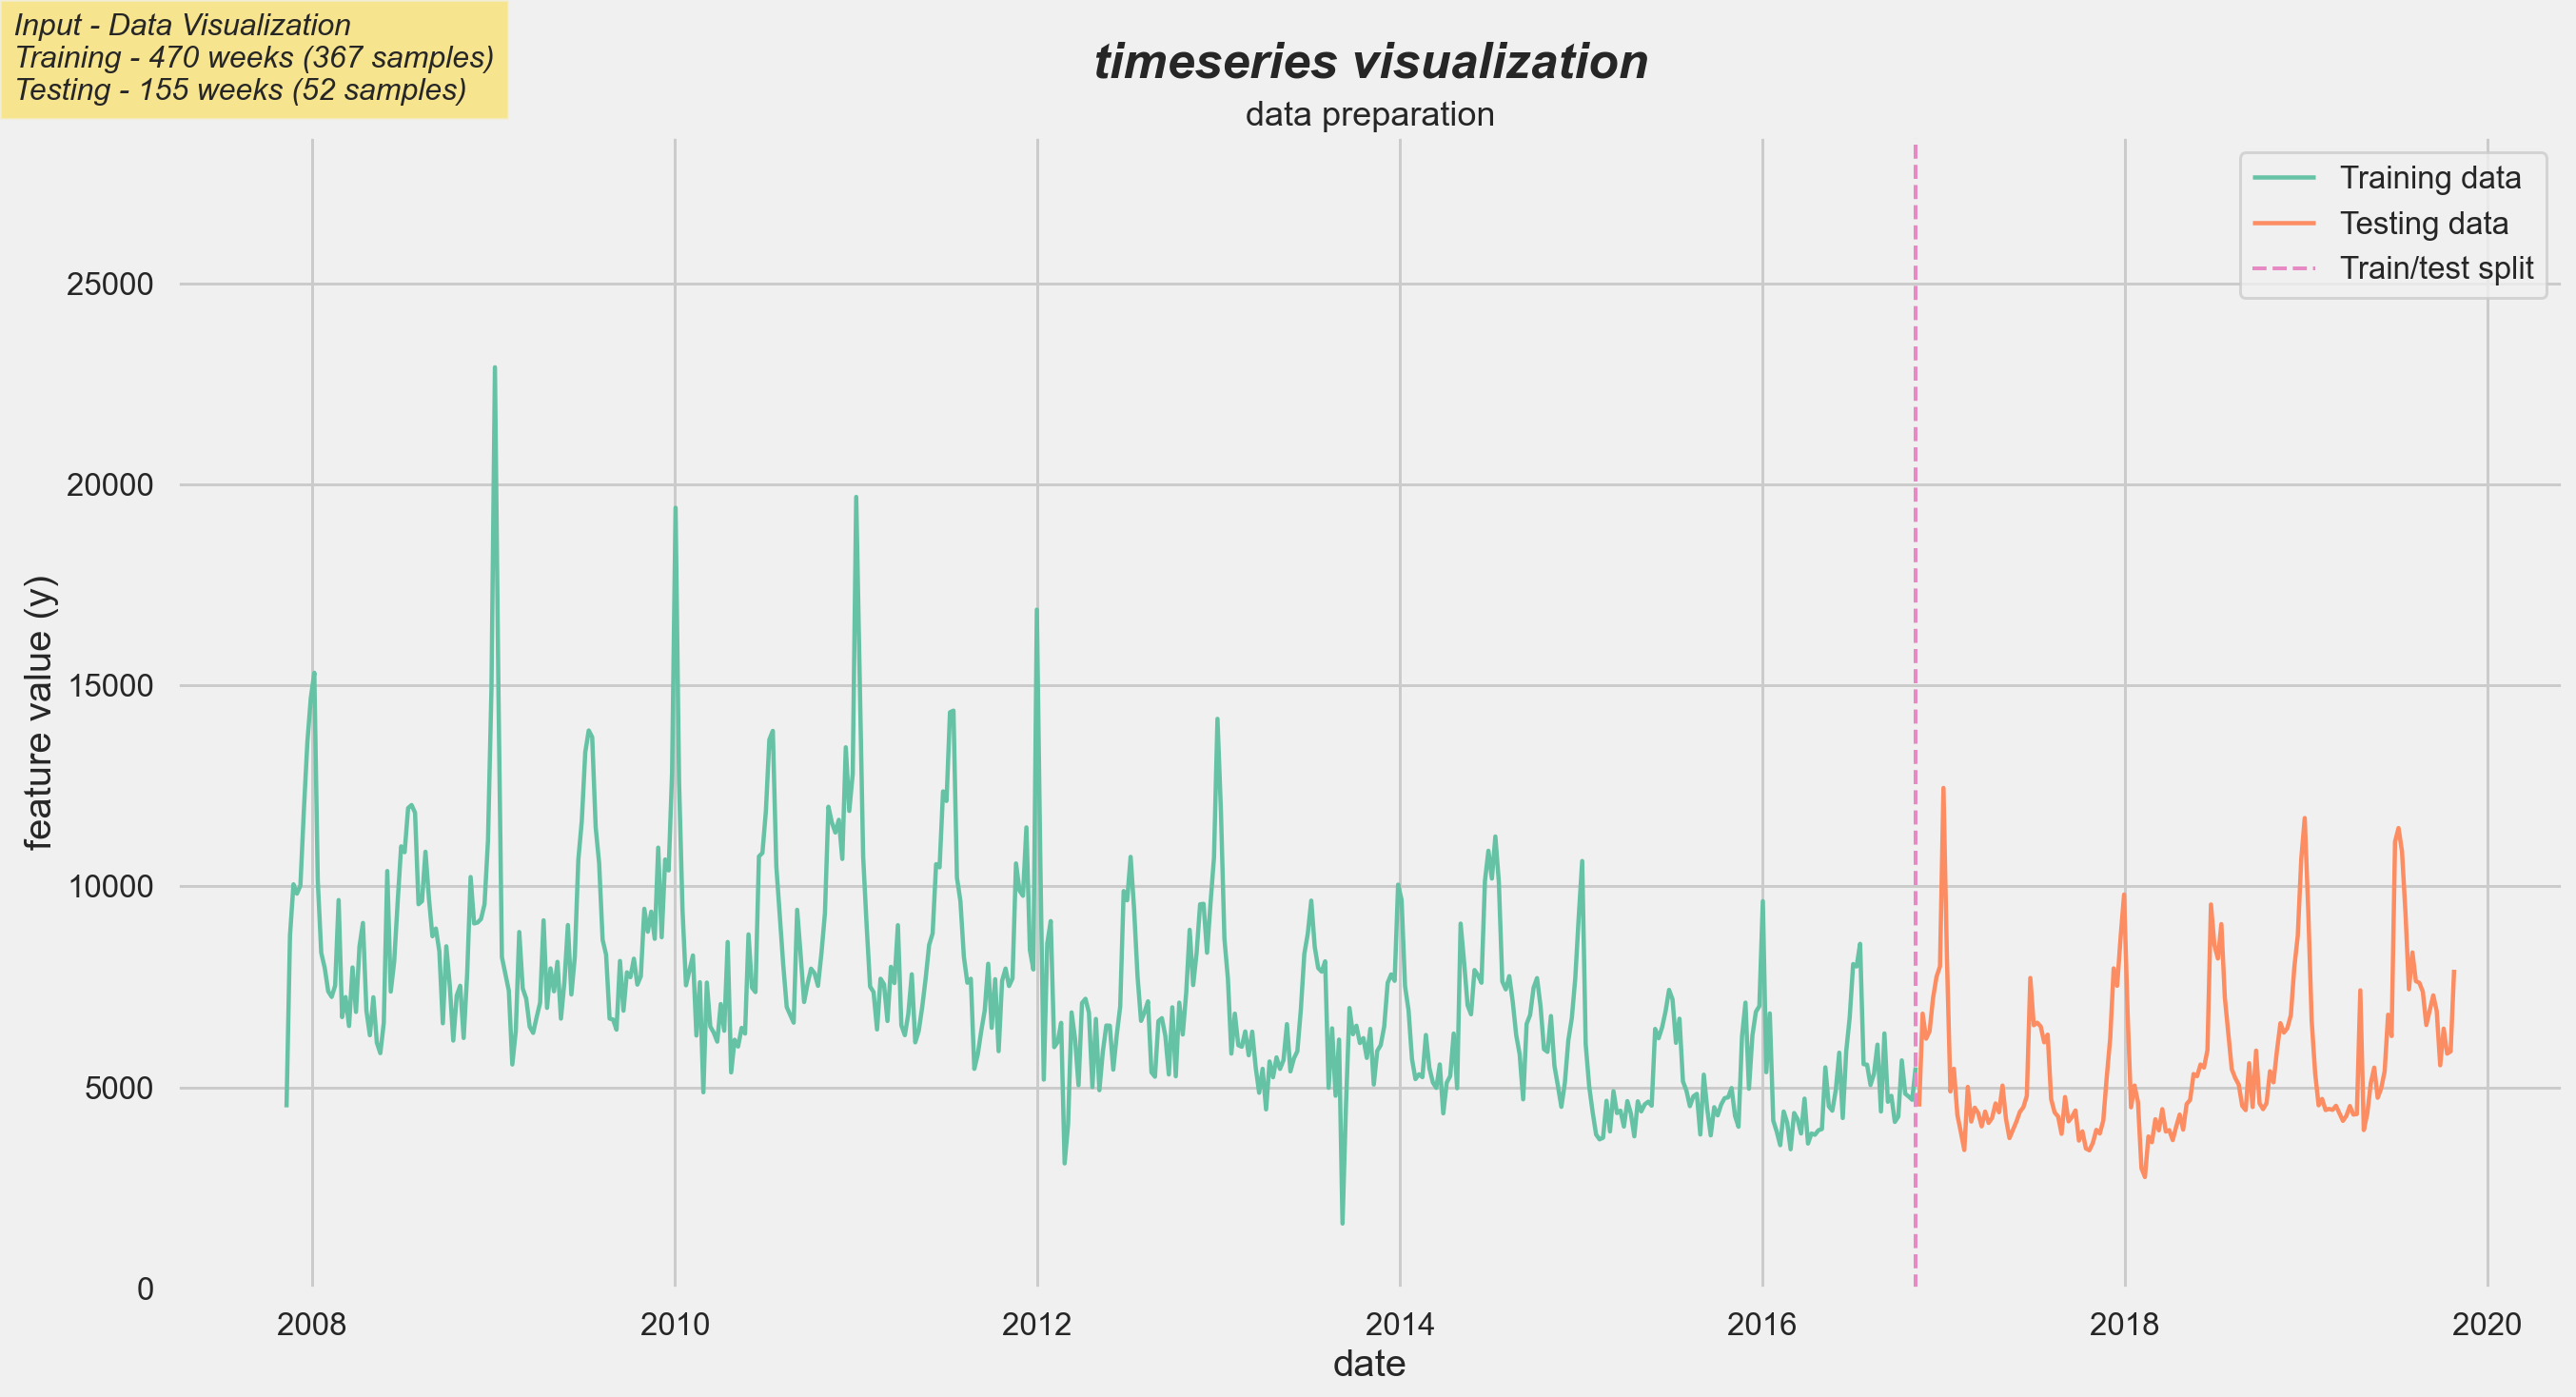

In [19]:
mwvh.plot_time_series(
    title='timeseries visualization',
    subtitle='data preparation',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    training=df_train,
    testing=df_test,
    ylabel='feature value (y)',
    split=threshold_date)

## Build the model

### Hyperparameters space definition

We'll use `RMSE` as our loss function to optimize (it is required to be defined as a function that can be compiled by `TensorFlow`):

In [20]:
def rmse_tf(y_true, y_pred):
    return tf.cast(
        tf.sqrt(
            tf.reduce_mean(
                tf.square(
                    tf.subtract(
                        y_pred,
                        y_true)))),
        dtype=tf.float32)

First, we define a model-building function. It takes an argument `hp` from which `Keras-Tuner` can sample hyperparameters:

In [21]:
def build_model_hp(
    hp, 
    loss_fn, 
    metrics_fn, 
    steps_in, 
    steps_out,
    n_features,
    n_lstm_layers,
    bidirectional_lstm,
    n_layers):

    # define model
    model = km.Sequential()

    layer = kl.LSTM(
        name='lstm_x',
        kernel_regularizer=kr.l2(
            l=hp.Float(
                name='lstm_x_kernel_regularizer_l2_alpha',
                min_value=1e-5,
                max_value=1e-3,
                default=1e-4,
                sampling='log')),
        bias_regularizer=kr.l2(
            l=hp.Float(
                name='lstm_x_bias_regularizer_l2_alpha',
                min_value=1e-5,
                max_value=1e-3,
                default=1e-4,
                sampling='log')),
        units=hp.Int(
            name='lstm_x_units',
            min_value=64,
            max_value=128,
            step=4), 
        input_shape=(steps_in, n_features),
        dropout=hp.Float(
            name='lstm_x_dropout',
            min_value=0.45,
            max_value=0.55,
            step=0.1),
        return_sequences=False)

    if bidirectional_lstm:
        model.add(
            kl.Bidirectional(
                name='lstm_x_bidirectional',
                layer=layer,
                merge_mode='ave'))
    else:
        model.add(layer)


    model.add(
        kl.RepeatVector(
            n=steps_out))

    
    for n_lstm in range(n_lstm_layers):
        layer = kl.LSTM(
            name='lstm_{0}'.format(n_lstm),
            kernel_regularizer=kr.l2(
                l=hp.Float(
                    name='lstm_{0}_kernel_regularizer_l2_alpha'.format(n_lstm),
                    min_value=1e-5,
                    max_value=1e-3,
                    default=1e-4,
                    sampling='log')),
            bias_regularizer=kr.l2(
                l=hp.Float(
                    name='lstm_{0}_bias_regularizer_l2_alpha'.format(n_lstm),
                    min_value=1e-5,
                    max_value=1e-3,
                    default=1e-4,
                    sampling='log')),
            units=hp.Int(
                name='lstm_{0}_units'.format(n_lstm),
                min_value=64,
                max_value=128,
                step=4), 
            dropout=hp.Float(
                name='lstm_{0}_dropout'.format(n_lstm),
                min_value=0.45,
                max_value=0.55,
                step=0.1),
            return_sequences=True)

        if bidirectional_lstm:
            model.add(
                kl.Bidirectional(
                    name='lstm_{0}_bidirectional'.format(n_lstm),
                    layer=layer,
                    merge_mode='ave'))
        else:
            model.add(layer)

    dense_dropout = hp.Float(
        name='dense_dropout',
        min_value=0.45,
        max_value=0.55,
        step=0.1)
    
    for n_layer in reversed(range(n_layers)):

        layer_size = (1 + n_layer) ** 2

        model.add(
            kl.TimeDistributed(
                name='dense_{0}_timedistributed'.format(n_layer),
                layer=kl.Dense(
                    name='dense_{0}'.format(n_layer),
                    activation='tanh',
                    kernel_regularizer=kr.l2(
                        l=hp.Float(
                            name='dense_{0}_kernel_regularizer_l2_alpha'.format(n_layer),
                            min_value=1e-5,
                            max_value=1e-3,
                            default=1e-4,
                            sampling='log')),
                    bias_regularizer=kr.l2(
                        l=hp.Float(
                            name='dense_{0}_bias_regularizer_l2_alpha'.format(n_layer),
                            min_value=1e-5,
                            max_value=1e-3,
                            default=1e-4,
                            sampling='log')),
                    units=hp.Int(
                        name='dense_{0}_units'.format(n_layer),
                        min_value=8*layer_size,
                        max_value=16*layer_size,
                        step=2*layer_size))))

        model.add(
            kl.Dropout(
                name='dense_{0}_dropout'.format(n_layer),
                rate=dense_dropout))

    model.add(
        kl.TimeDistributed(
            name='dense_output_timedistributed',
            layer=kl.Dense(
                name='dense_output',
                kernel_regularizer=kr.l2(
                    l=hp.Float(
                        name='dense_output_kernel_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        default=1e-4,
                        sampling='log')),
                bias_regularizer=kr.l2(
                    l=hp.Float(
                        name='dense_output_bias_regularizer_l2_alpha',
                        min_value=1e-5,
                        max_value=1e-3,
                        default=1e-4,
                        sampling='log')),
                activation='linear',
                units=1)))

    model.compile(
        loss=loss_fn,
        metrics=metrics_fn,
        optimizer=ko.Adam(
            learning_rate=hp.Float(
                name='learning_rate',
                min_value=1e-5,
                max_value=1e-3,
                default=1e-4,
                sampling='log')))

    return model

It is required to define a partial wrapping the build-function to ensure the signature matches the `Keras-Tuner` expectations:

In [22]:
build_model = partial(
    build_model_hp,
    loss_fn=rmse_tf, 
    metrics_fn=None,
    steps_in=params['input_size'], 
    steps_out=params['output_size'], 
    n_features=len(params['features']),
    n_lstm_layers=1,
    bidirectional_lstm=True,
    n_layers=2)

We can create an `Hyperband` tuner to do the hyperparameter search. The main objective is to **minimize** the `validation loss`.

In [23]:
tuner = ktt.Hyperband(
    build_model,
    project_name=params['experiment_name'],
    directory='.tuner',
    objective='val_loss',
    allow_new_entries=True,
    tune_new_entries=True,
    hyperband_iterations=params['hyperband_iterations'],
    max_epochs=params['max_epochs'])

### Default model analysis

We can start by evaluating a **default** model, i.e. a model for which all **hyperparameters** are set to their **default** value. As we did not specified a **default** value for all hyperparameters in the `build_model_hp` function, for such ones their **min** value will be used instead. To create a **default** model we just need to pass a fresh `kte.hyperparameters.HyperParameters()` class instance to the `build`function.

In [24]:
default_model = tuner.hypermodel.build(
    kte.hyperparameters.HyperParameters())

Let's **fit** this model using the data we loaded earlier:

In [25]:
#hide_output
default_history = default_model.fit(
    x=X_train, 
    y=y_train, 
    shuffle=True,
    batch_size=params['batch_size'],
    validation_data=(X_test, y_test),
    epochs=params['max_epochs'], 
    callbacks=[ 
        kc.EarlyStopping(
            monitor='val_loss', 
            patience=params['patience'],
            verbose=1,
            mode='min',
            restore_best_weights=True),
        kc.TerminateOnNaN()
    ],
    verbose=2)

Epoch 1/250
12/12 - 4s - loss: 0.5395 - val_loss: 0.4940
Epoch 2/250
12/12 - 0s - loss: 0.4476 - val_loss: 0.3619
Epoch 3/250
12/12 - 0s - loss: 0.3888 - val_loss: 0.2668
Epoch 4/250
12/12 - 0s - loss: 0.3735 - val_loss: 0.2528
Epoch 5/250
12/12 - 0s - loss: 0.3670 - val_loss: 0.2545
Epoch 6/250
12/12 - 0s - loss: 0.3617 - val_loss: 0.2573
Epoch 7/250
12/12 - 0s - loss: 0.3607 - val_loss: 0.2500
Epoch 8/250
12/12 - 0s - loss: 0.3534 - val_loss: 0.2469
Epoch 9/250
12/12 - 0s - loss: 0.3523 - val_loss: 0.2451
Epoch 10/250
12/12 - 0s - loss: 0.3497 - val_loss: 0.2434
Epoch 11/250
12/12 - 0s - loss: 0.3465 - val_loss: 0.2411
Epoch 12/250
12/12 - 0s - loss: 0.3437 - val_loss: 0.2388
Epoch 13/250
12/12 - 0s - loss: 0.3458 - val_loss: 0.2410
Epoch 14/250
12/12 - 0s - loss: 0.3416 - val_loss: 0.2365
Epoch 15/250
12/12 - 0s - loss: 0.3384 - val_loss: 0.2347
Epoch 16/250
12/12 - 0s - loss: 0.3372 - val_loss: 0.2349
Epoch 17/250
12/12 - 0s - loss: 0.3350 - val_loss: 0.2325
Epoch 18/250
12/12 - 0s

Epoch 142/250
12/12 - 0s - loss: 0.2464 - val_loss: 0.1956
Epoch 143/250
12/12 - 0s - loss: 0.2447 - val_loss: 0.2123
Epoch 144/250
12/12 - 0s - loss: 0.2462 - val_loss: 0.1947
Epoch 145/250
12/12 - 0s - loss: 0.2424 - val_loss: 0.2010
Epoch 146/250
12/12 - 0s - loss: 0.2413 - val_loss: 0.1973
Epoch 147/250
12/12 - 0s - loss: 0.2401 - val_loss: 0.2064
Epoch 148/250
12/12 - 0s - loss: 0.2425 - val_loss: 0.2052
Epoch 149/250
12/12 - 0s - loss: 0.2408 - val_loss: 0.2059
Epoch 150/250
12/12 - 0s - loss: 0.2381 - val_loss: 0.2019
Epoch 151/250
12/12 - 0s - loss: 0.2407 - val_loss: 0.1988
Epoch 152/250
12/12 - 0s - loss: 0.2413 - val_loss: 0.2114
Epoch 153/250
12/12 - 0s - loss: 0.2385 - val_loss: 0.1976
Epoch 154/250
12/12 - 0s - loss: 0.2413 - val_loss: 0.2002
Epoch 155/250
12/12 - 0s - loss: 0.2391 - val_loss: 0.1982
Epoch 156/250
12/12 - 0s - loss: 0.2378 - val_loss: 0.2059
Epoch 157/250
12/12 - 0s - loss: 0.2369 - val_loss: 0.1918
Epoch 158/250
12/12 - 0s - loss: 0.2383 - val_loss: 0.20

We can save this default model and use the [Netron](https://github.com/lutzroeder/netron) application to create a visual representation of it.

In [26]:
default_model.save(
    './.models/{0}_default.h5'.format(
        params['experiment_name']))

And here is a visual **plot** of the model made using the [Netron](https://github.com/lutzroeder/netron) application.

![](./images/lstm-model.png)

Here is a **text** version of the model's **architecture** made with **Keras** itself.

In [27]:
default_model.summary(
    line_length=120)

Model: "sequential"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
lstm_x_bidirectional (Bidirectional)                  (None, 64)                                      35328             
________________________________________________________________________________________________________________________
repeat_vector (RepeatVector)                          (None, 13, 64)                                  0                 
________________________________________________________________________________________________________________________
lstm_0_bidirectional (Bidirectional)                  (None, 13, 64)                                  66048             
________________________________________________________________________________________________________________________
dense_1_time

We can see the optimization process on the chart below.

In [28]:
def plot_model_history(history):
    '''
    Summarizes the history for all loss functions,
    throughout the epochs.
    '''
    for fn in list(history.history.keys()):
        plt.plot(history.history[fn])
    
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(list(history.history.keys()), loc='upper right')

    plt.show()

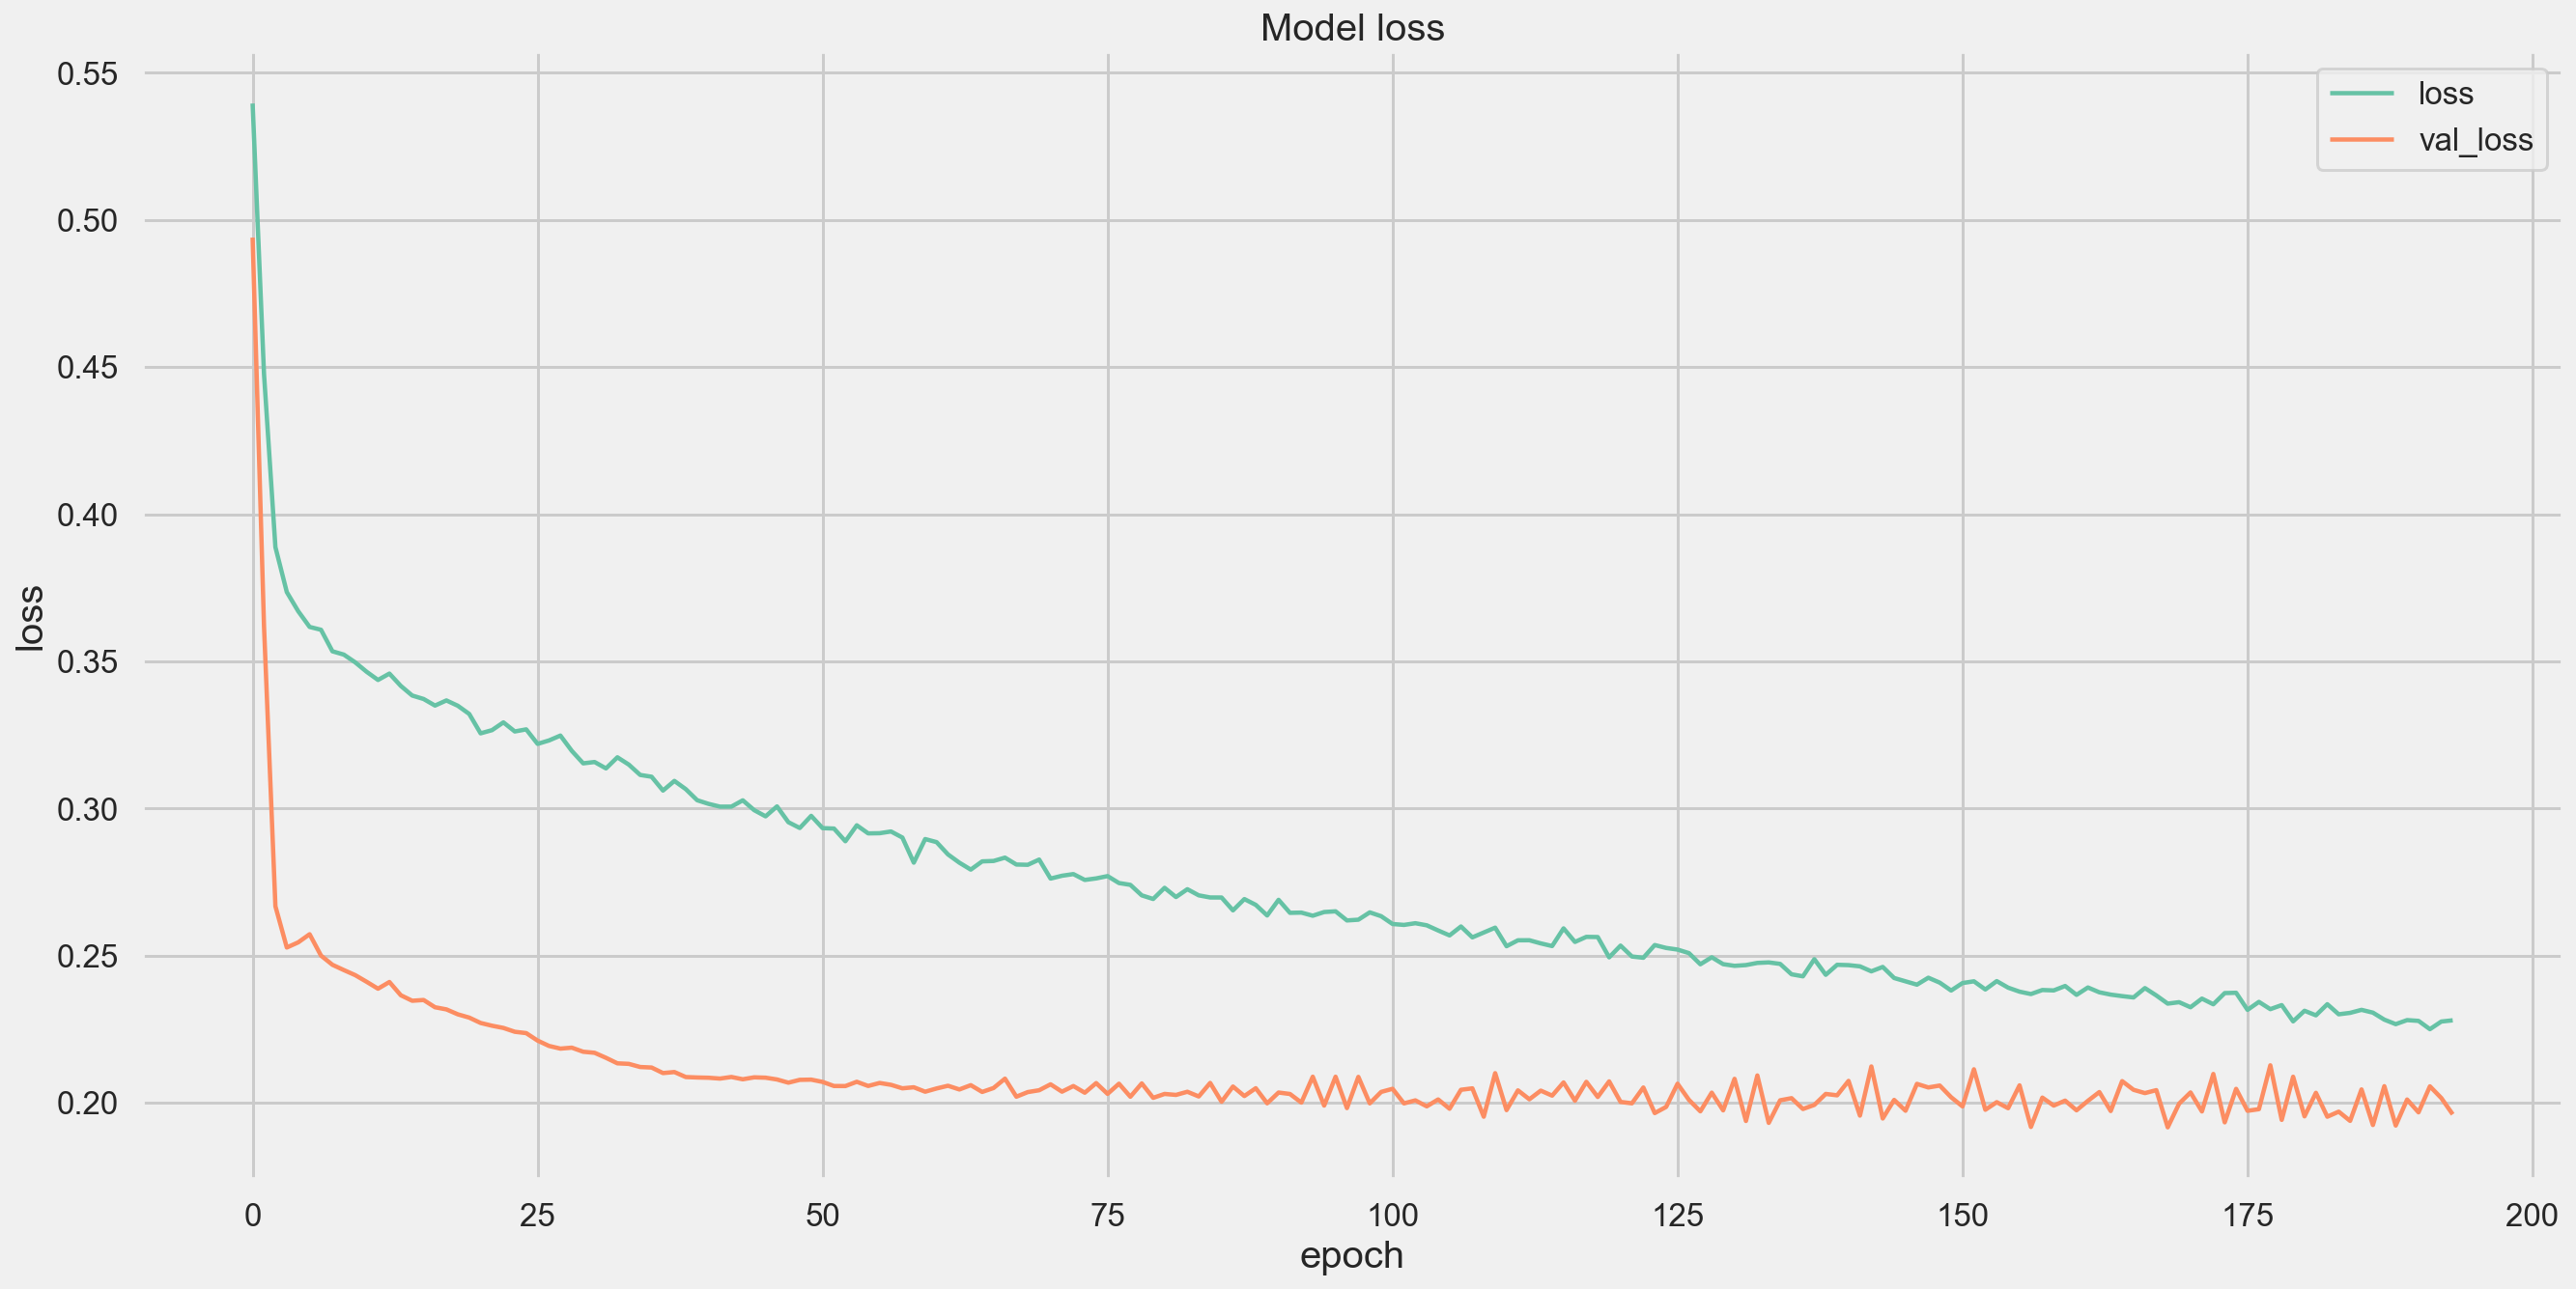

In [29]:
plot_model_history(history=default_history)

Let's zoom in and focus on the **last n weeks** of data.

In [63]:
def get_n_weeks_window(n_weeks):
    return dt.timedelta(weeks=n_weeks)

We need a functions to compute the various model scores.

In [33]:
def score(loss_fn, y_true, y_pred):
    if loss_fn == 'RMSE':
        return skme.mean_squared_error(
            y_true=y_true,
            y_pred=y_pred,
            squared=False)
    elif loss_fn == 'MSLE':
        return skme.mean_squared_log_error(
            y_true=y_true,
            y_pred=y_pred)
    elif loss_fn == 'MSE':
        return skme.mean_squared_error(
            y_true=y_true,
            y_pred=y_pred,
            squared=True)    
    elif loss_fn == 'R2':
        return skme.r2_score(
            y_true=y_true,
            y_pred=y_pred)    
    elif loss_fn == 'MAE':
        return skme.mean_absolute_error(
            y_true=y_true,
            y_pred=y_pred)
    elif loss_fn == 'MAPE':
        return skme.mean_absolute_percentage_error(
            y_true=y_true,
            y_pred=y_pred)

We can **process** de predicted values returned by the model. The model sequencialy produces `params['output_size']` data points (i.e. the number of weeks of data points predicted). Predictions will enventually overlap, so we can use the `mean` function to get a good candidate of the current value. Similarly, the `min` and the `max` will provide a convenient confidence interval.

In [58]:
def process_predictions(data, X, y, scaler_out, model):
    
    data_pre = data.copy()
    
    scores = []
    predictions = []
    score_functions = ['RMSE', 'MSE', 'R2', 'MAE', 'MAPE']

    lag_data = params['lag_size']
    steps_lag = 0

    if lag_data is not None and len(lag_data) > 0:
        steps_lag = max(lag_data)

    y_preds = model.predict(
        x=X,
        batch_size=params['batch_size'],
        verbose=0)

    y_true_array = []
    y_pred_array = []
    
    for i in range(y.shape[0]):

        t_score = {}

        y_true = scaler_out.inverse_transform(y[i])
        y_pred = scaler_out.inverse_transform(y_preds[i])

        y_true_array.append(y_true)
        y_pred_array.append(y_pred)
        
        for score_function in score_functions:
            t_score[score_function] = score(
                score_function, 
                y_true,
                y_pred)

        scores.append(t_score)

        prediction = [np.nan] * data_pre.shape[0]

        for j in range(len(y_true)):
            position = steps_lag + i + j + params['input_size']
            prediction[position] = y_pred[j][0]

        predictions.append(
            prediction)

    df_scores = pd.DataFrame.from_records(scores)

    data_pre['yhat_lower'] = pd.DataFrame(predictions).min().values
    data_pre['yhat_upper'] = pd.DataFrame(predictions).max().values
    data_pre['yhat'] = pd.DataFrame(predictions).mean().values
    data_pre['yhat_last'] = predictions[-1]
    data_pre['residual'] = abs(data_pre['yhat'] - data_pre['y'])
    
    pred = {
        'df': data_pre,
        'scores': df_scores,
        'y_true': y_true_array,
        'y_pred': y_pred_array,
        'predictions': predictions
    }

    return pred

In [59]:
pred_default = process_predictions(
    data=df, 
    X=X, 
    y=y, 
    scaler_out=scaler_out, 
    model=default_model)

We can see on the chart that the predictions are quite **basic** but still properly following the local trend as well as the seasonal variations.

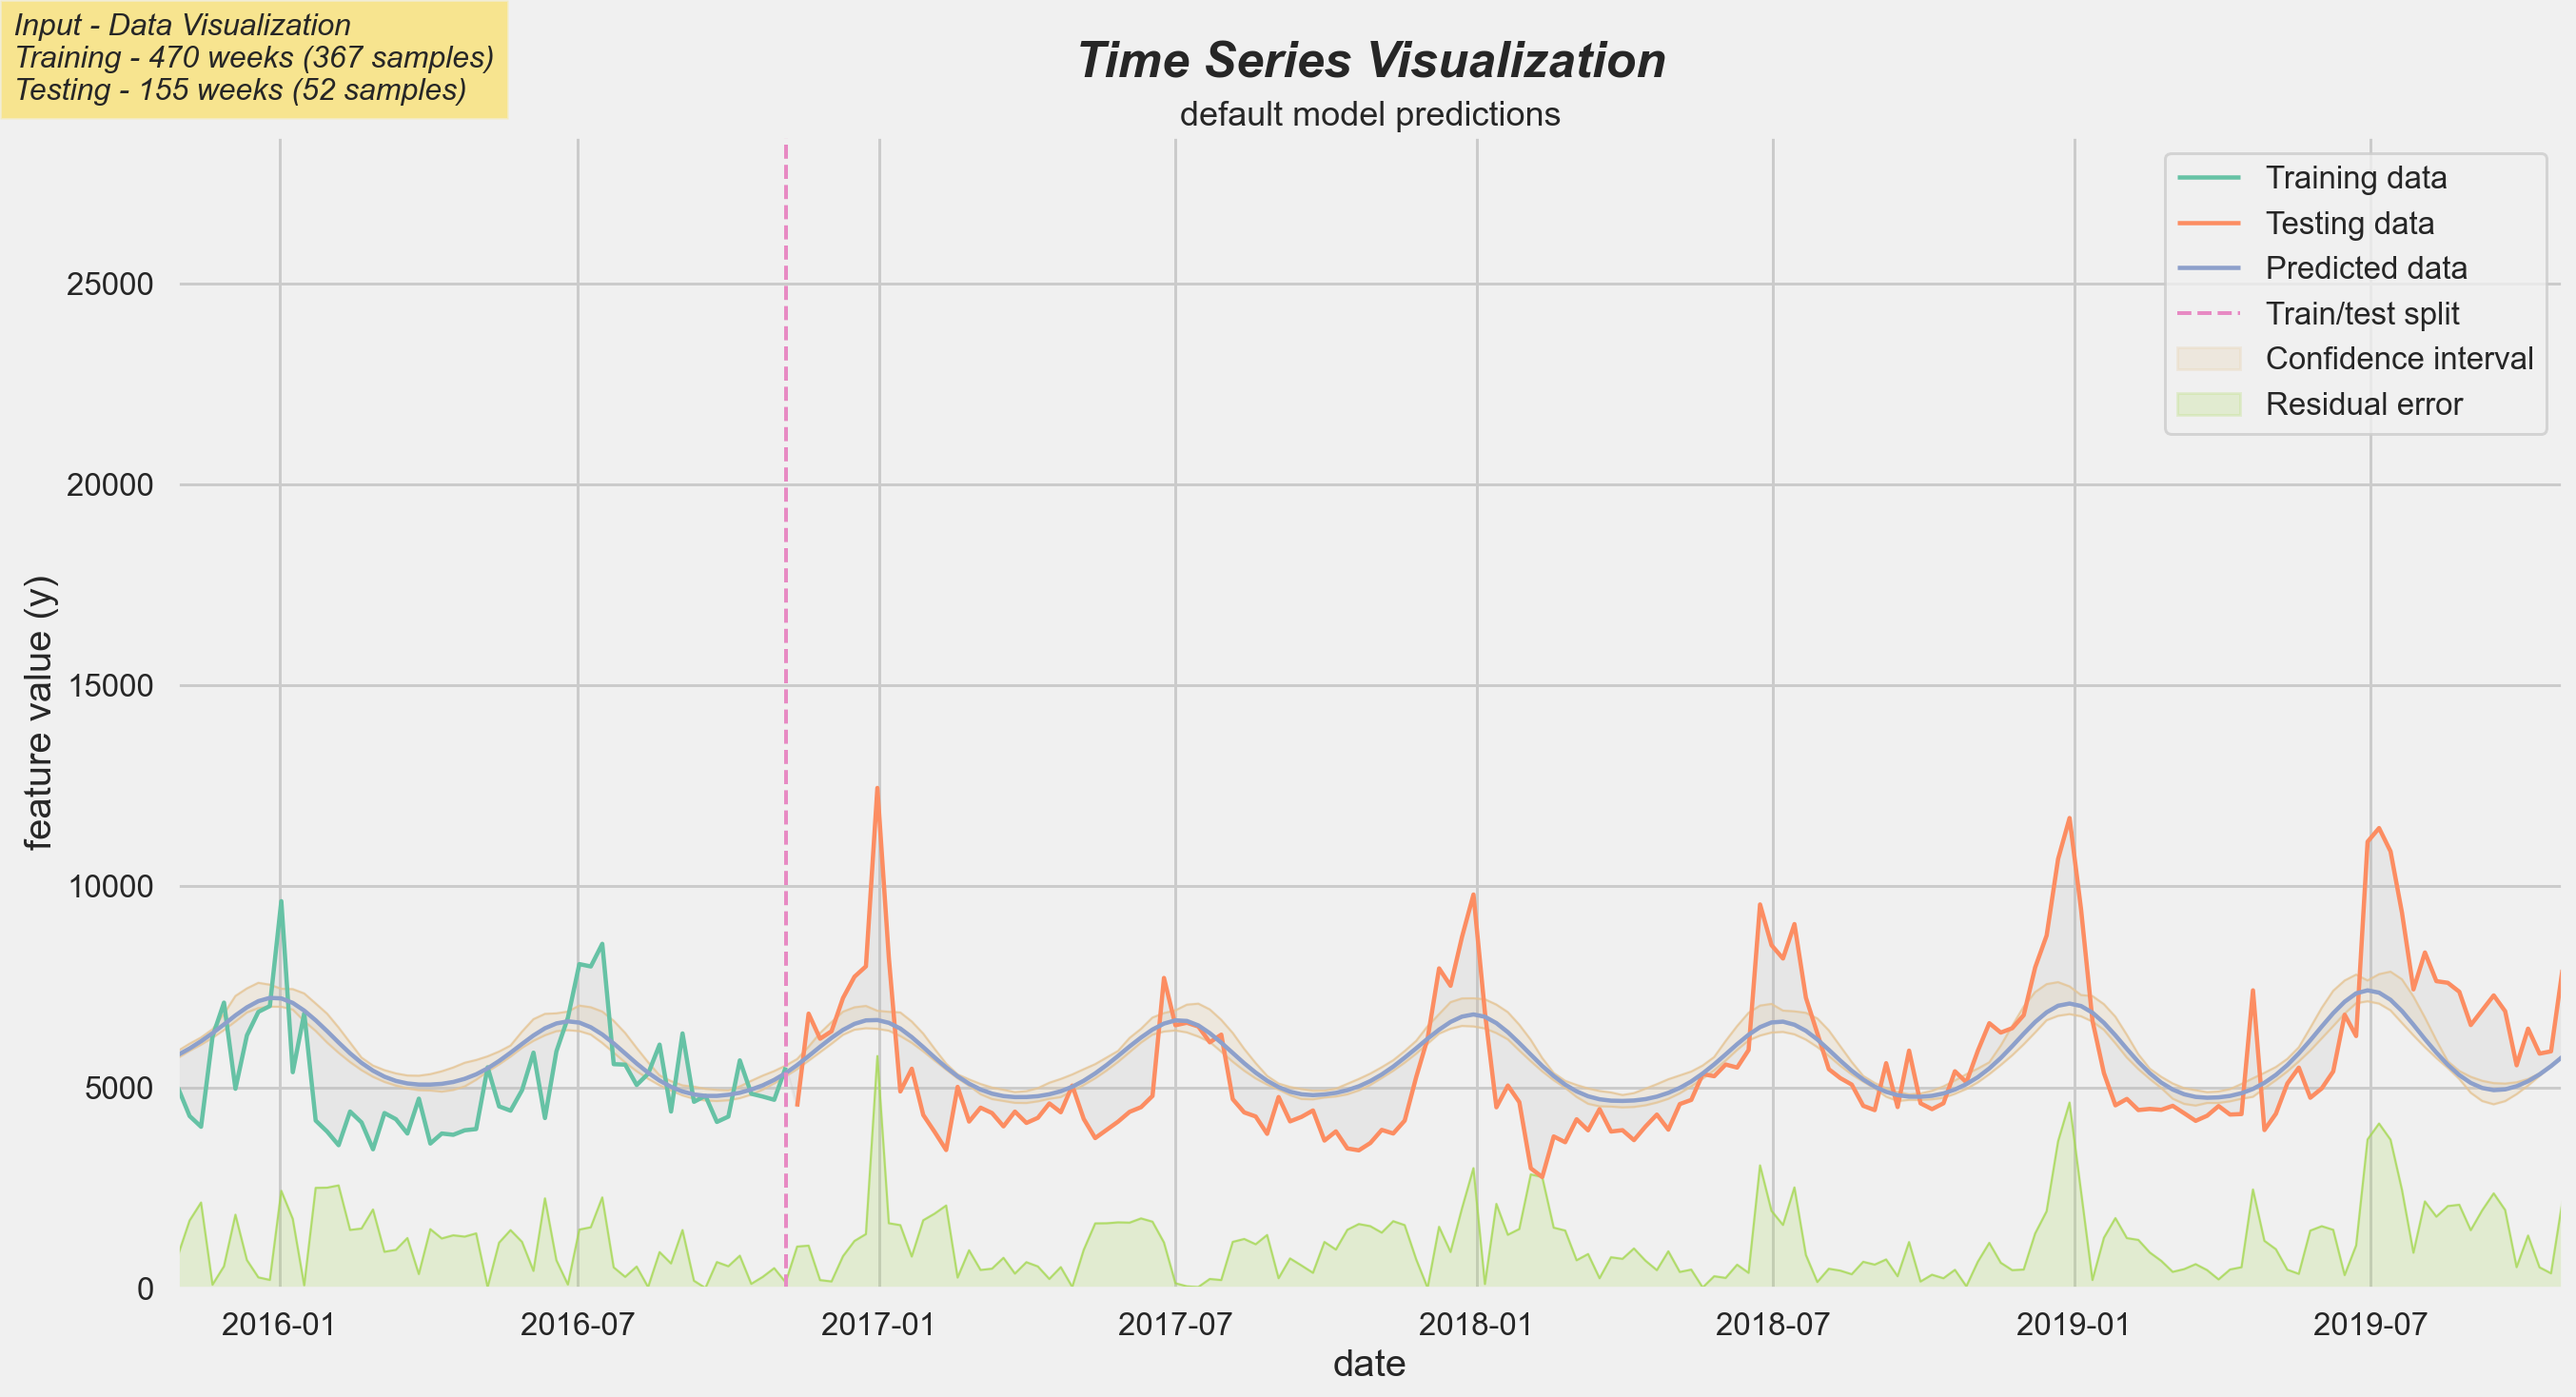

In [71]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='default model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    training=df_train,
    testing=df_test,
    confidence=pred_default['df'],
    confidence_label='Confidence interval',
    prediction=pred_default['df'],
    residual=pred_default['df'],
    residual_label='Residual error',
    ylabel='feature value (y)',
    split=threshold_date,
    window_size=get_n_weeks_window(16*params['output_size']))

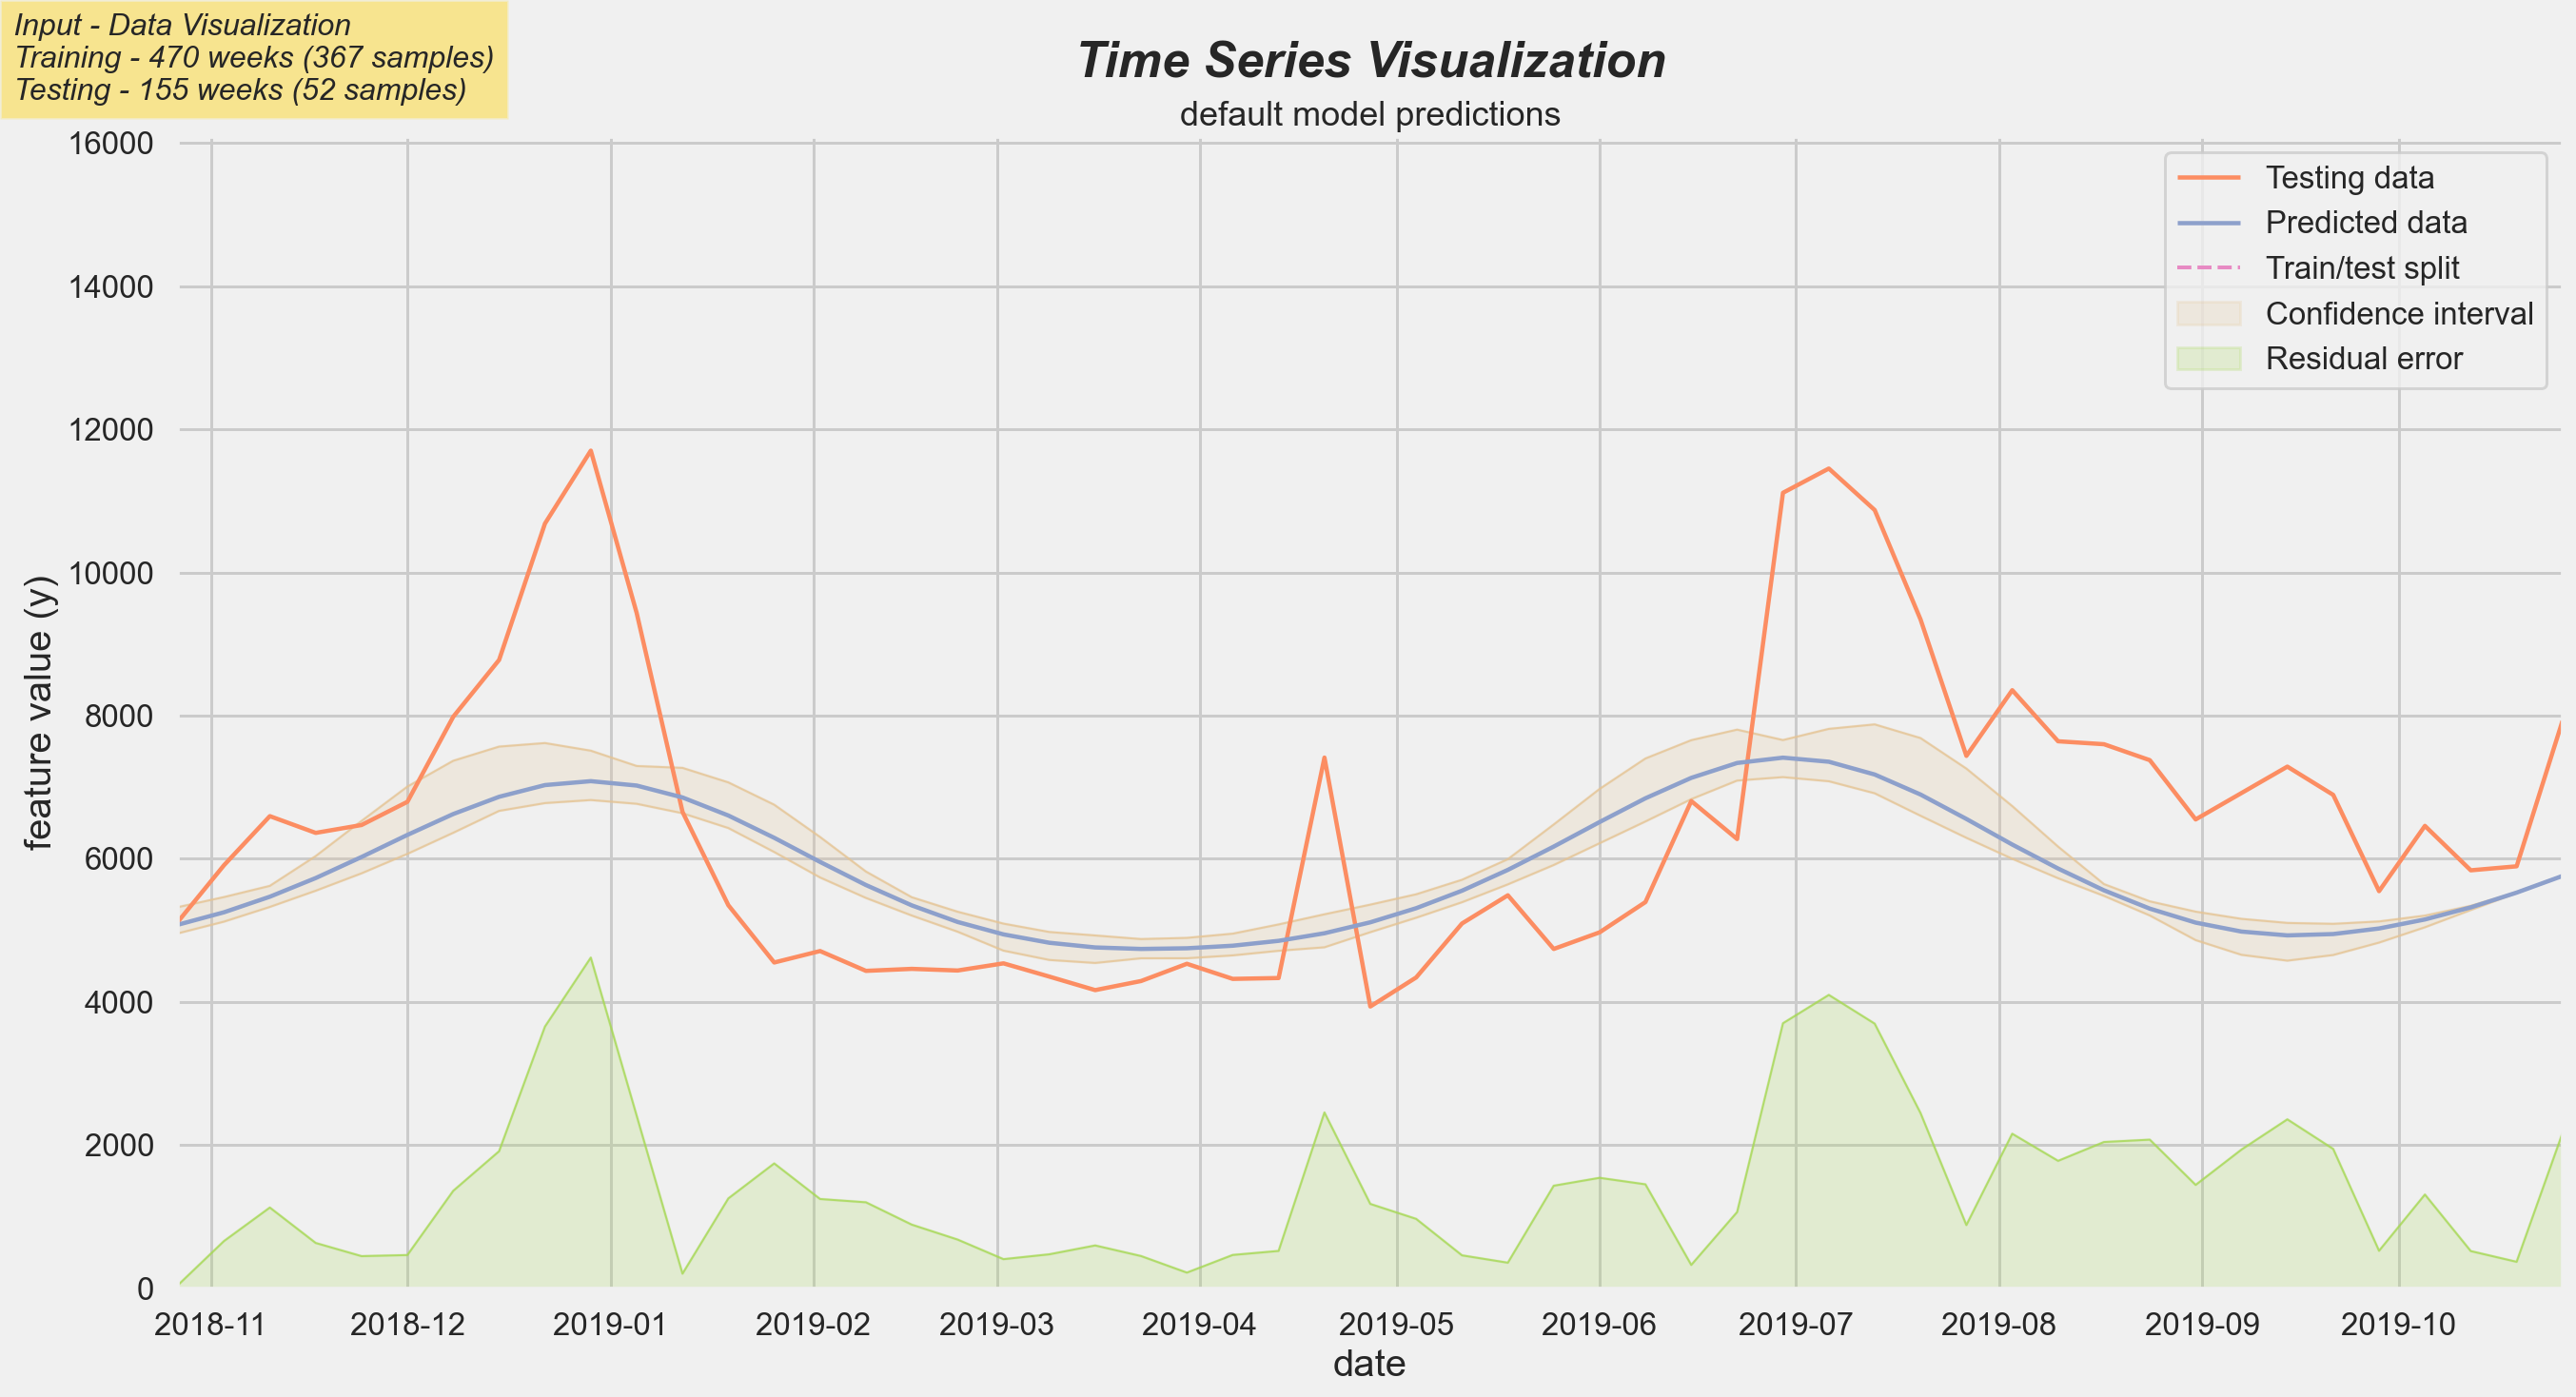

In [69]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='default model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    #training=df_train,
    testing=df_test,
    confidence=pred_default['df'],
    confidence_label='Confidence interval',
    prediction=pred_default['df'],
    prediction_col='yhat',
    residual=pred_default['df'],
    residual_label='Residual error',
    ylabel='feature value (y)',
    split=threshold_date,
    window_size=get_n_weeks_window(4*params['output_size']))

### Hyperparamters tuning

`Keras-Tuner` comes with an efficient `Hyperband` tuner that can search and find the optimized set of parameters. Let's try and find a better model than the **default** one.

We need this class to clear cell output after each **trial**:

In [41]:
class ClearTrainingOutput(kc.Callback):
    def on_train_end(*args, **kwargs):
        ids.clear_output(wait=True)

We can performs a search for best **hyperparameters** configuration.

In [42]:
tuner.search(
    x=X_train, 
    y=y_train, 
    shuffle=True,
    batch_size=params['batch_size'],
    validation_data=(X_test, y_test),
    epochs=params['max_epochs'], 
    callbacks=[ 
        ClearTrainingOutput(),
        kc.EarlyStopping(
            monitor='val_loss', 
            patience=params['patience'],
            verbose=1,
            mode='min',
            restore_best_weights=True),
        kc.TerminateOnNaN()
    ],
    verbose=2)

Trial 2175 Complete [00h 02m 07s]
val_loss: 0.3842664062976837

Best val_loss So Far: 0.14739209413528442
Total elapsed time: 15h 21m 45s
INFO:tensorflow:Oracle triggered exit


We can print out the **results summary**:

In [43]:
tuner.results_summary(num_trials=1)

Results summary
Results in .tuner\2021-05-31-1622706773552-LSTM+01
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
lstm_x_kernel_regularizer_l2_alpha: 2.9668268997167553e-05
lstm_x_bias_regularizer_l2_alpha: 0.00038567127811387804
lstm_x_units: 108
lstm_x_dropout: 0.45
lstm_0_kernel_regularizer_l2_alpha: 8.535913146840679e-05
lstm_0_bias_regularizer_l2_alpha: 0.00020659115658466396
lstm_0_units: 96
lstm_0_dropout: 0.55
dense_dropout: 0.55
dense_1_kernel_regularizer_l2_alpha: 5.832680412025289e-05
dense_1_bias_regularizer_l2_alpha: 0.0007561268585695314
dense_1_units: 40
dense_0_kernel_regularizer_l2_alpha: 2.5000059665917292e-05
dense_0_bias_regularizer_l2_alpha: 3.8711445593710885e-05
dense_0_units: 8
dense_output_kernel_regularizer_l2_alpha: 2.526185546309563e-05
dense_output_bias_regularizer_l2_alpha: 0.0009009438052949248
learning_rate: 0.0009089947410825655
tuner/epochs: 250
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Sco

And we can retrieve the best **hyperparameters** configuration:

In [44]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

Which we can use to build the model with the best **hyperparameters** configuration:

In [45]:
model = tuner.hypermodel.build(best_params)

Let's **fit** this model using the training data used during the search:

In [46]:
#hide_output
history = model.fit(
    x=X_train, 
    y=y_train, 
    shuffle=True,
    batch_size=params['batch_size'],
    validation_data=(X_test, y_test),
    epochs=params['max_epochs'], 
    callbacks=[ 
        kc.EarlyStopping(
            monitor='val_loss', 
            patience=params['patience'],
            verbose=1,
            mode='min',
            restore_best_weights=True),
        kc.TerminateOnNaN()
    ],
    verbose=2)

Epoch 1/250
12/12 - 3s - loss: 0.5044 - val_loss: 0.3457
Epoch 2/250
12/12 - 0s - loss: 0.4568 - val_loss: 0.3525
Epoch 3/250
12/12 - 0s - loss: 0.4365 - val_loss: 0.3516
Epoch 4/250
12/12 - 0s - loss: 0.4267 - val_loss: 0.3296
Epoch 5/250
12/12 - 0s - loss: 0.4119 - val_loss: 0.3203
Epoch 6/250
12/12 - 0s - loss: 0.4029 - val_loss: 0.3129
Epoch 7/250
12/12 - 0s - loss: 0.3900 - val_loss: 0.2979
Epoch 8/250
12/12 - 0s - loss: 0.3837 - val_loss: 0.2965
Epoch 9/250
12/12 - 0s - loss: 0.3714 - val_loss: 0.2854
Epoch 10/250
12/12 - 0s - loss: 0.3671 - val_loss: 0.2862
Epoch 11/250
12/12 - 0s - loss: 0.3579 - val_loss: 0.2899
Epoch 12/250
12/12 - 0s - loss: 0.3530 - val_loss: 0.2931
Epoch 13/250
12/12 - 0s - loss: 0.3442 - val_loss: 0.2770
Epoch 14/250
12/12 - 0s - loss: 0.3401 - val_loss: 0.2807
Epoch 15/250
12/12 - 0s - loss: 0.3400 - val_loss: 0.2785
Epoch 16/250
12/12 - 0s - loss: 0.3325 - val_loss: 0.2717
Epoch 17/250
12/12 - 0s - loss: 0.3291 - val_loss: 0.2738
Epoch 18/250
12/12 - 0s

It is a good time to **save** our model for future use:

In [47]:
model.save(
    './.models/{0}.h5'.format(
        params['experiment_name']))

We can see the optimization process on the chart below.

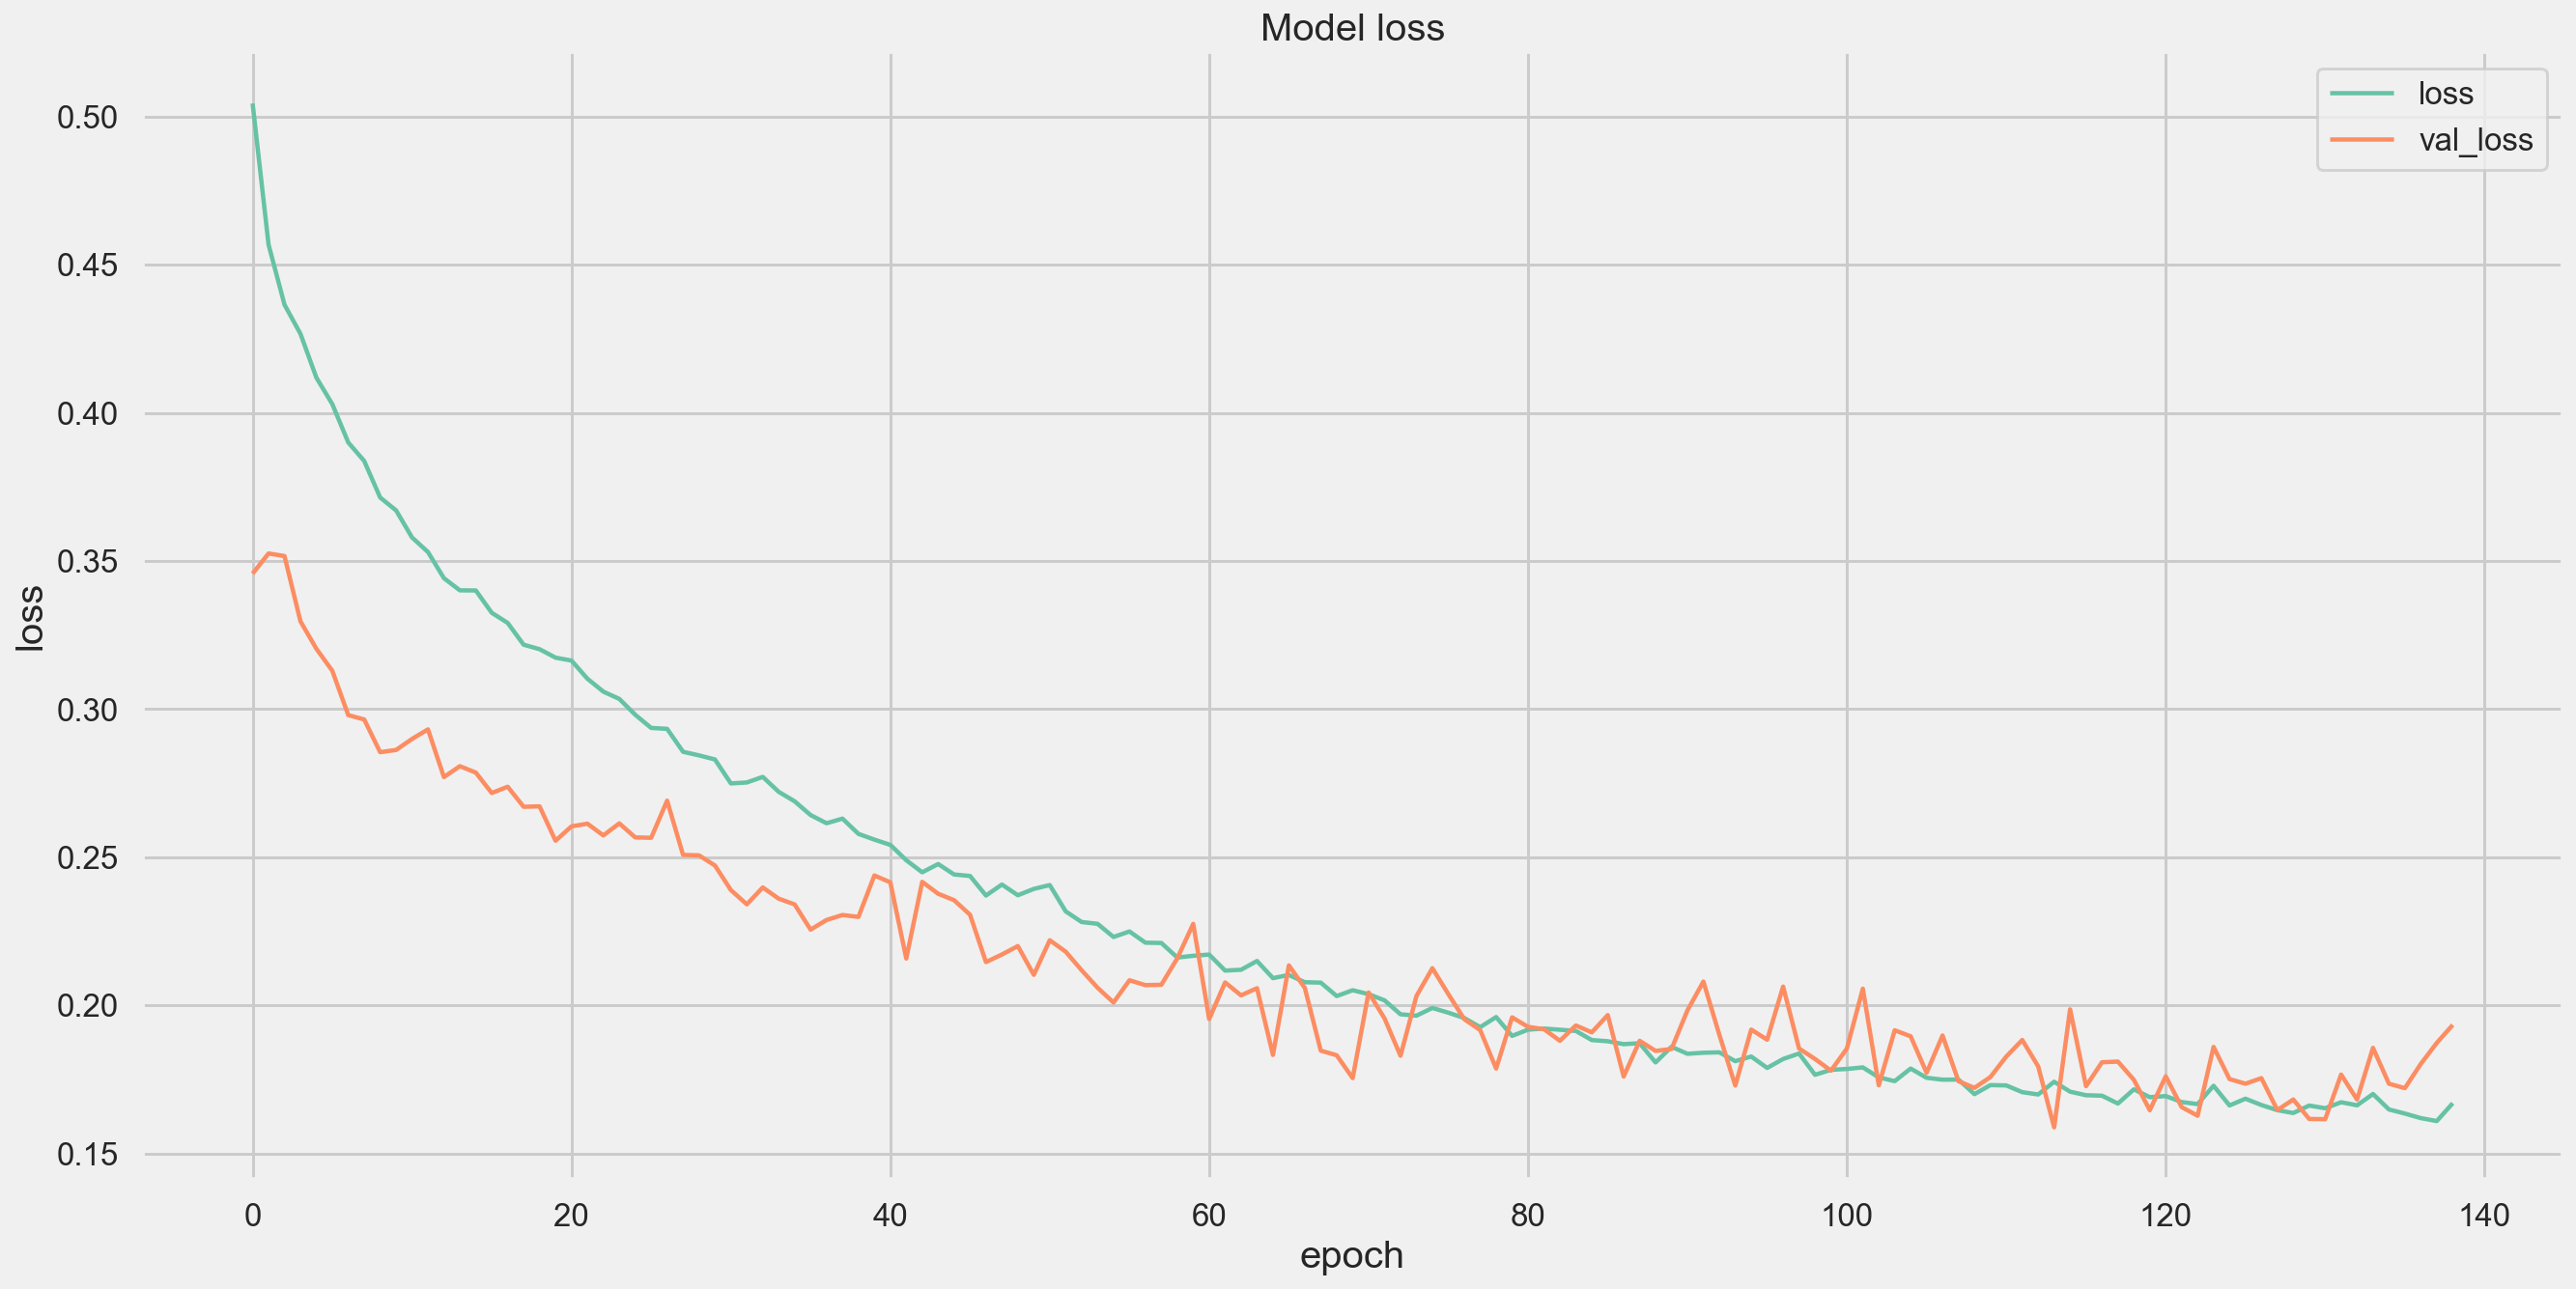

In [48]:
plot_model_history(history=history)

Here are our model **scores**.

In [72]:
pred_optimized = process_predictions(
    data=df, 
    X=X, 
    y=y, 
    scaler_out=scaler_out, 
    model=model)

We can plot the predictions we've made with our **optimized** model.

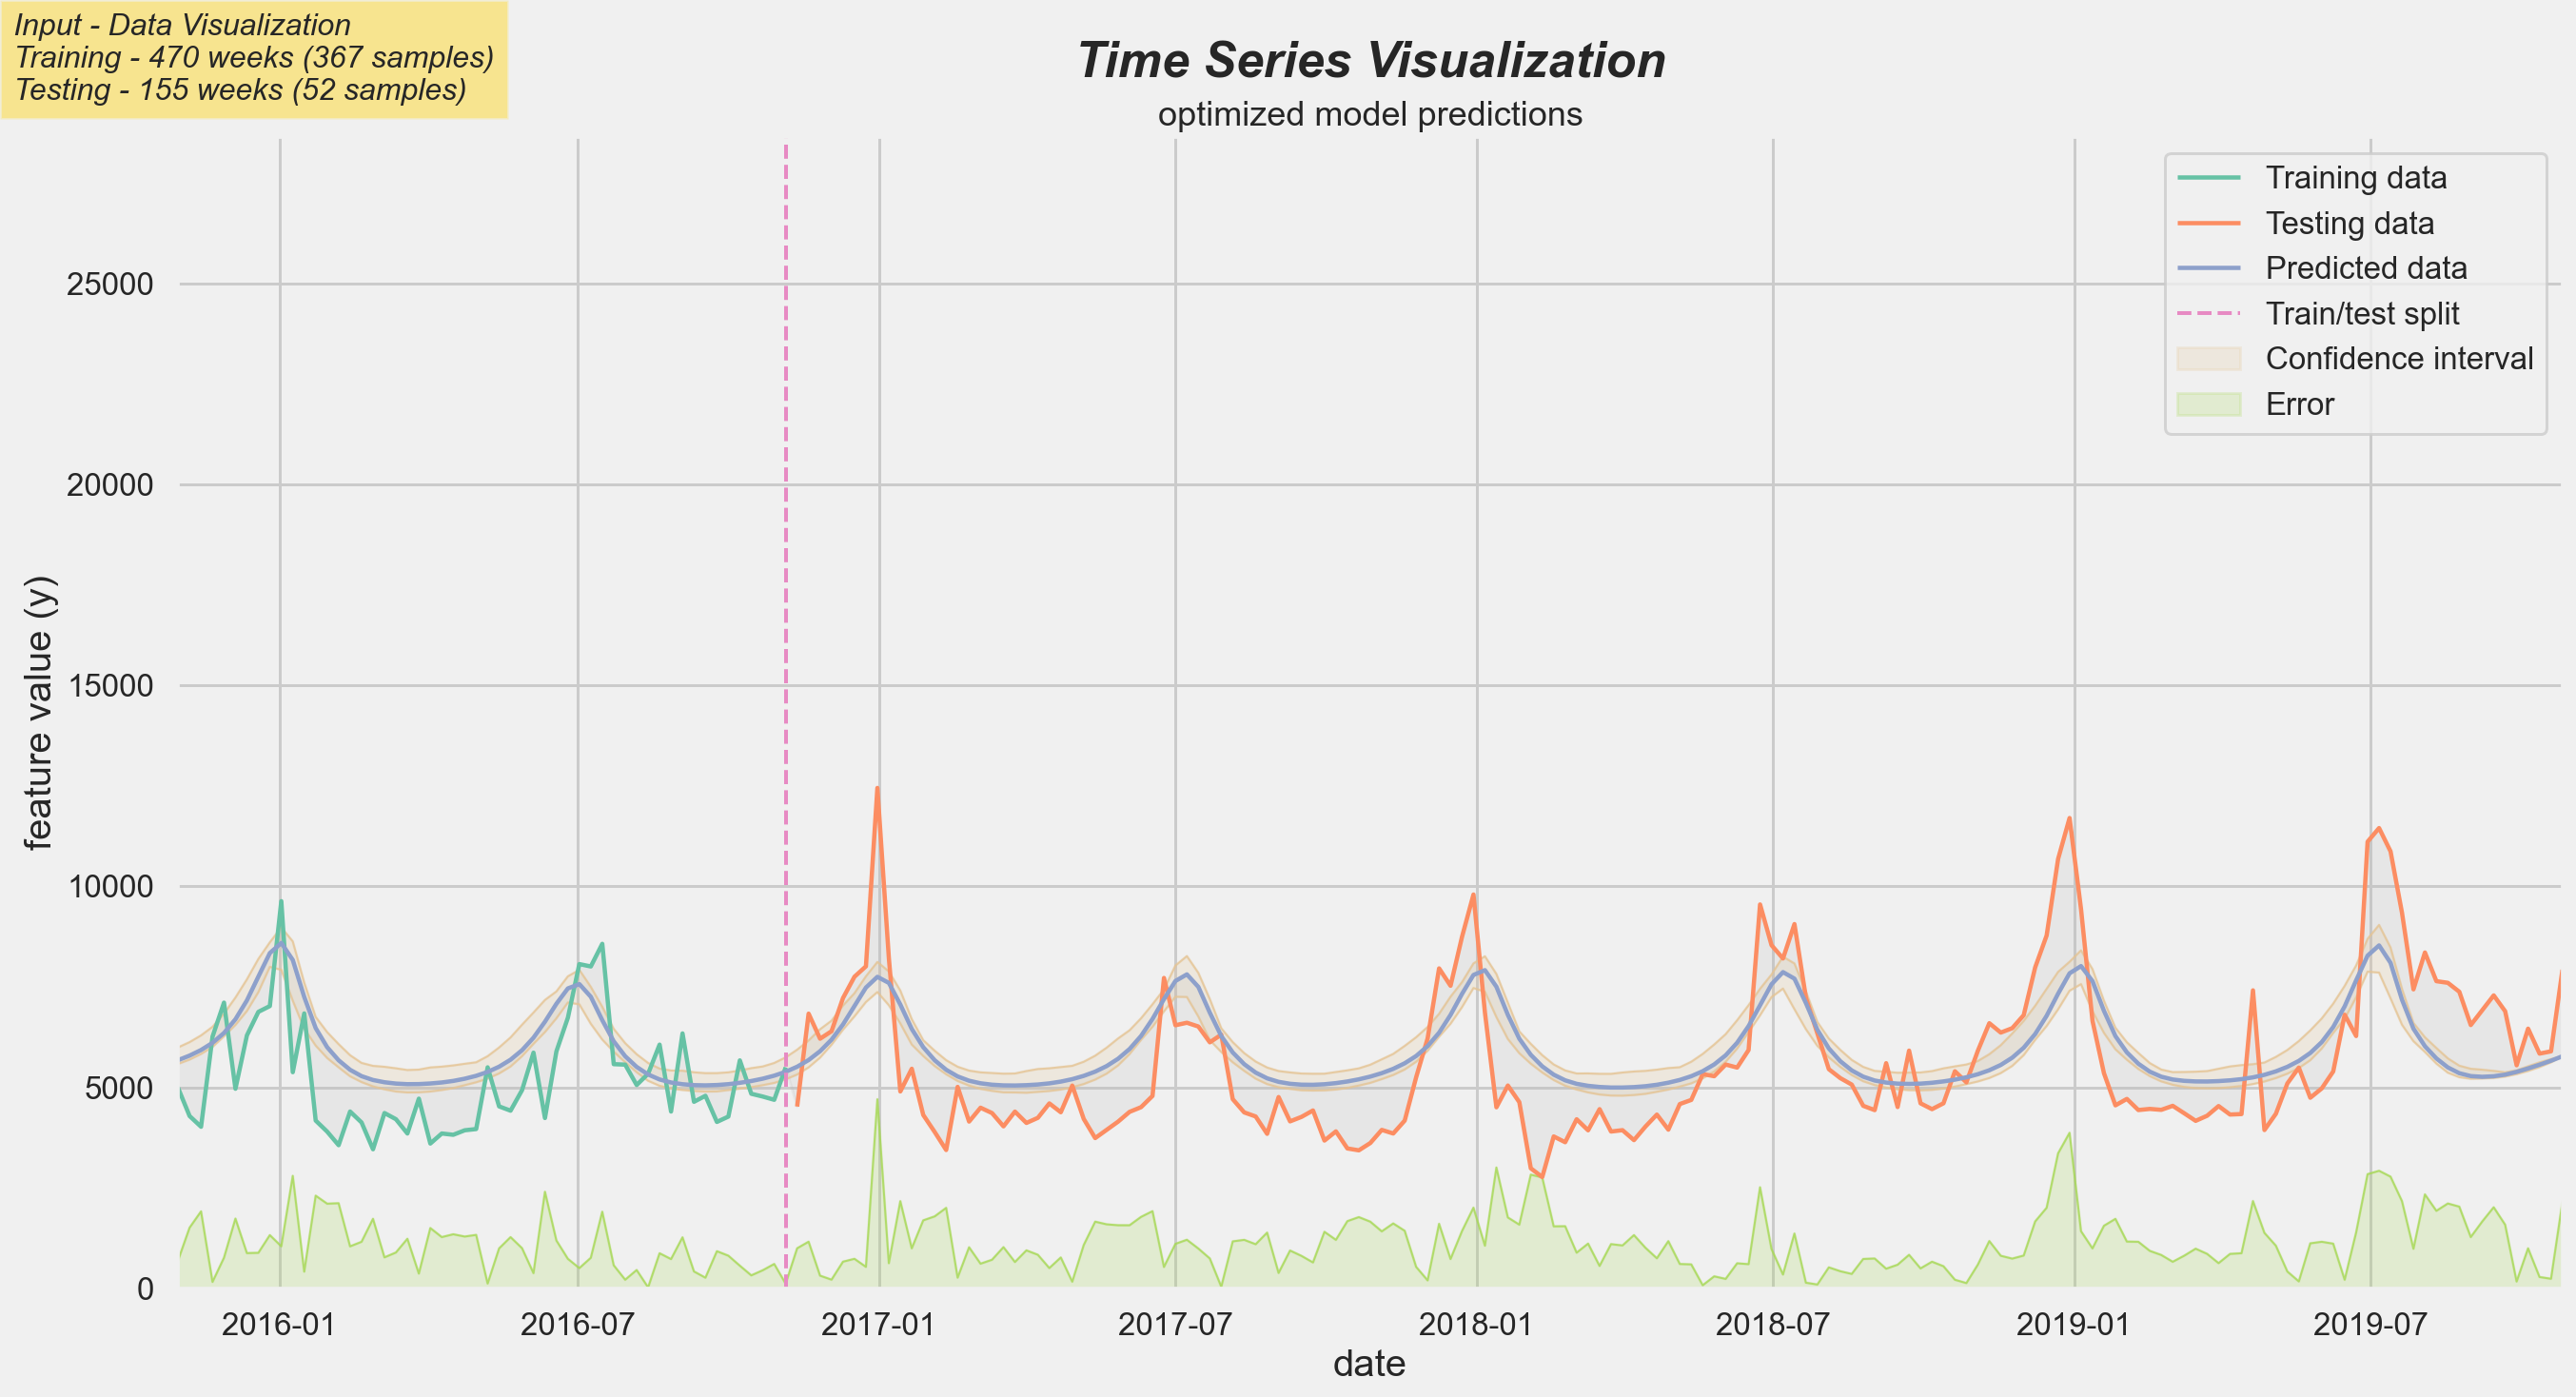

In [75]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='optimized model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    training=df_train,
    testing=df_test,
    confidence=pred_optimized['df'],
    confidence_label='Confidence interval',
    prediction=pred_optimized['df'],
    residual=pred_optimized['df'],
    ylabel='feature value (y)',
    split=threshold_date,
    window_size=get_n_weeks_window(16*params['output_size']))

This is the last year of data for the **optimized** model predictions:

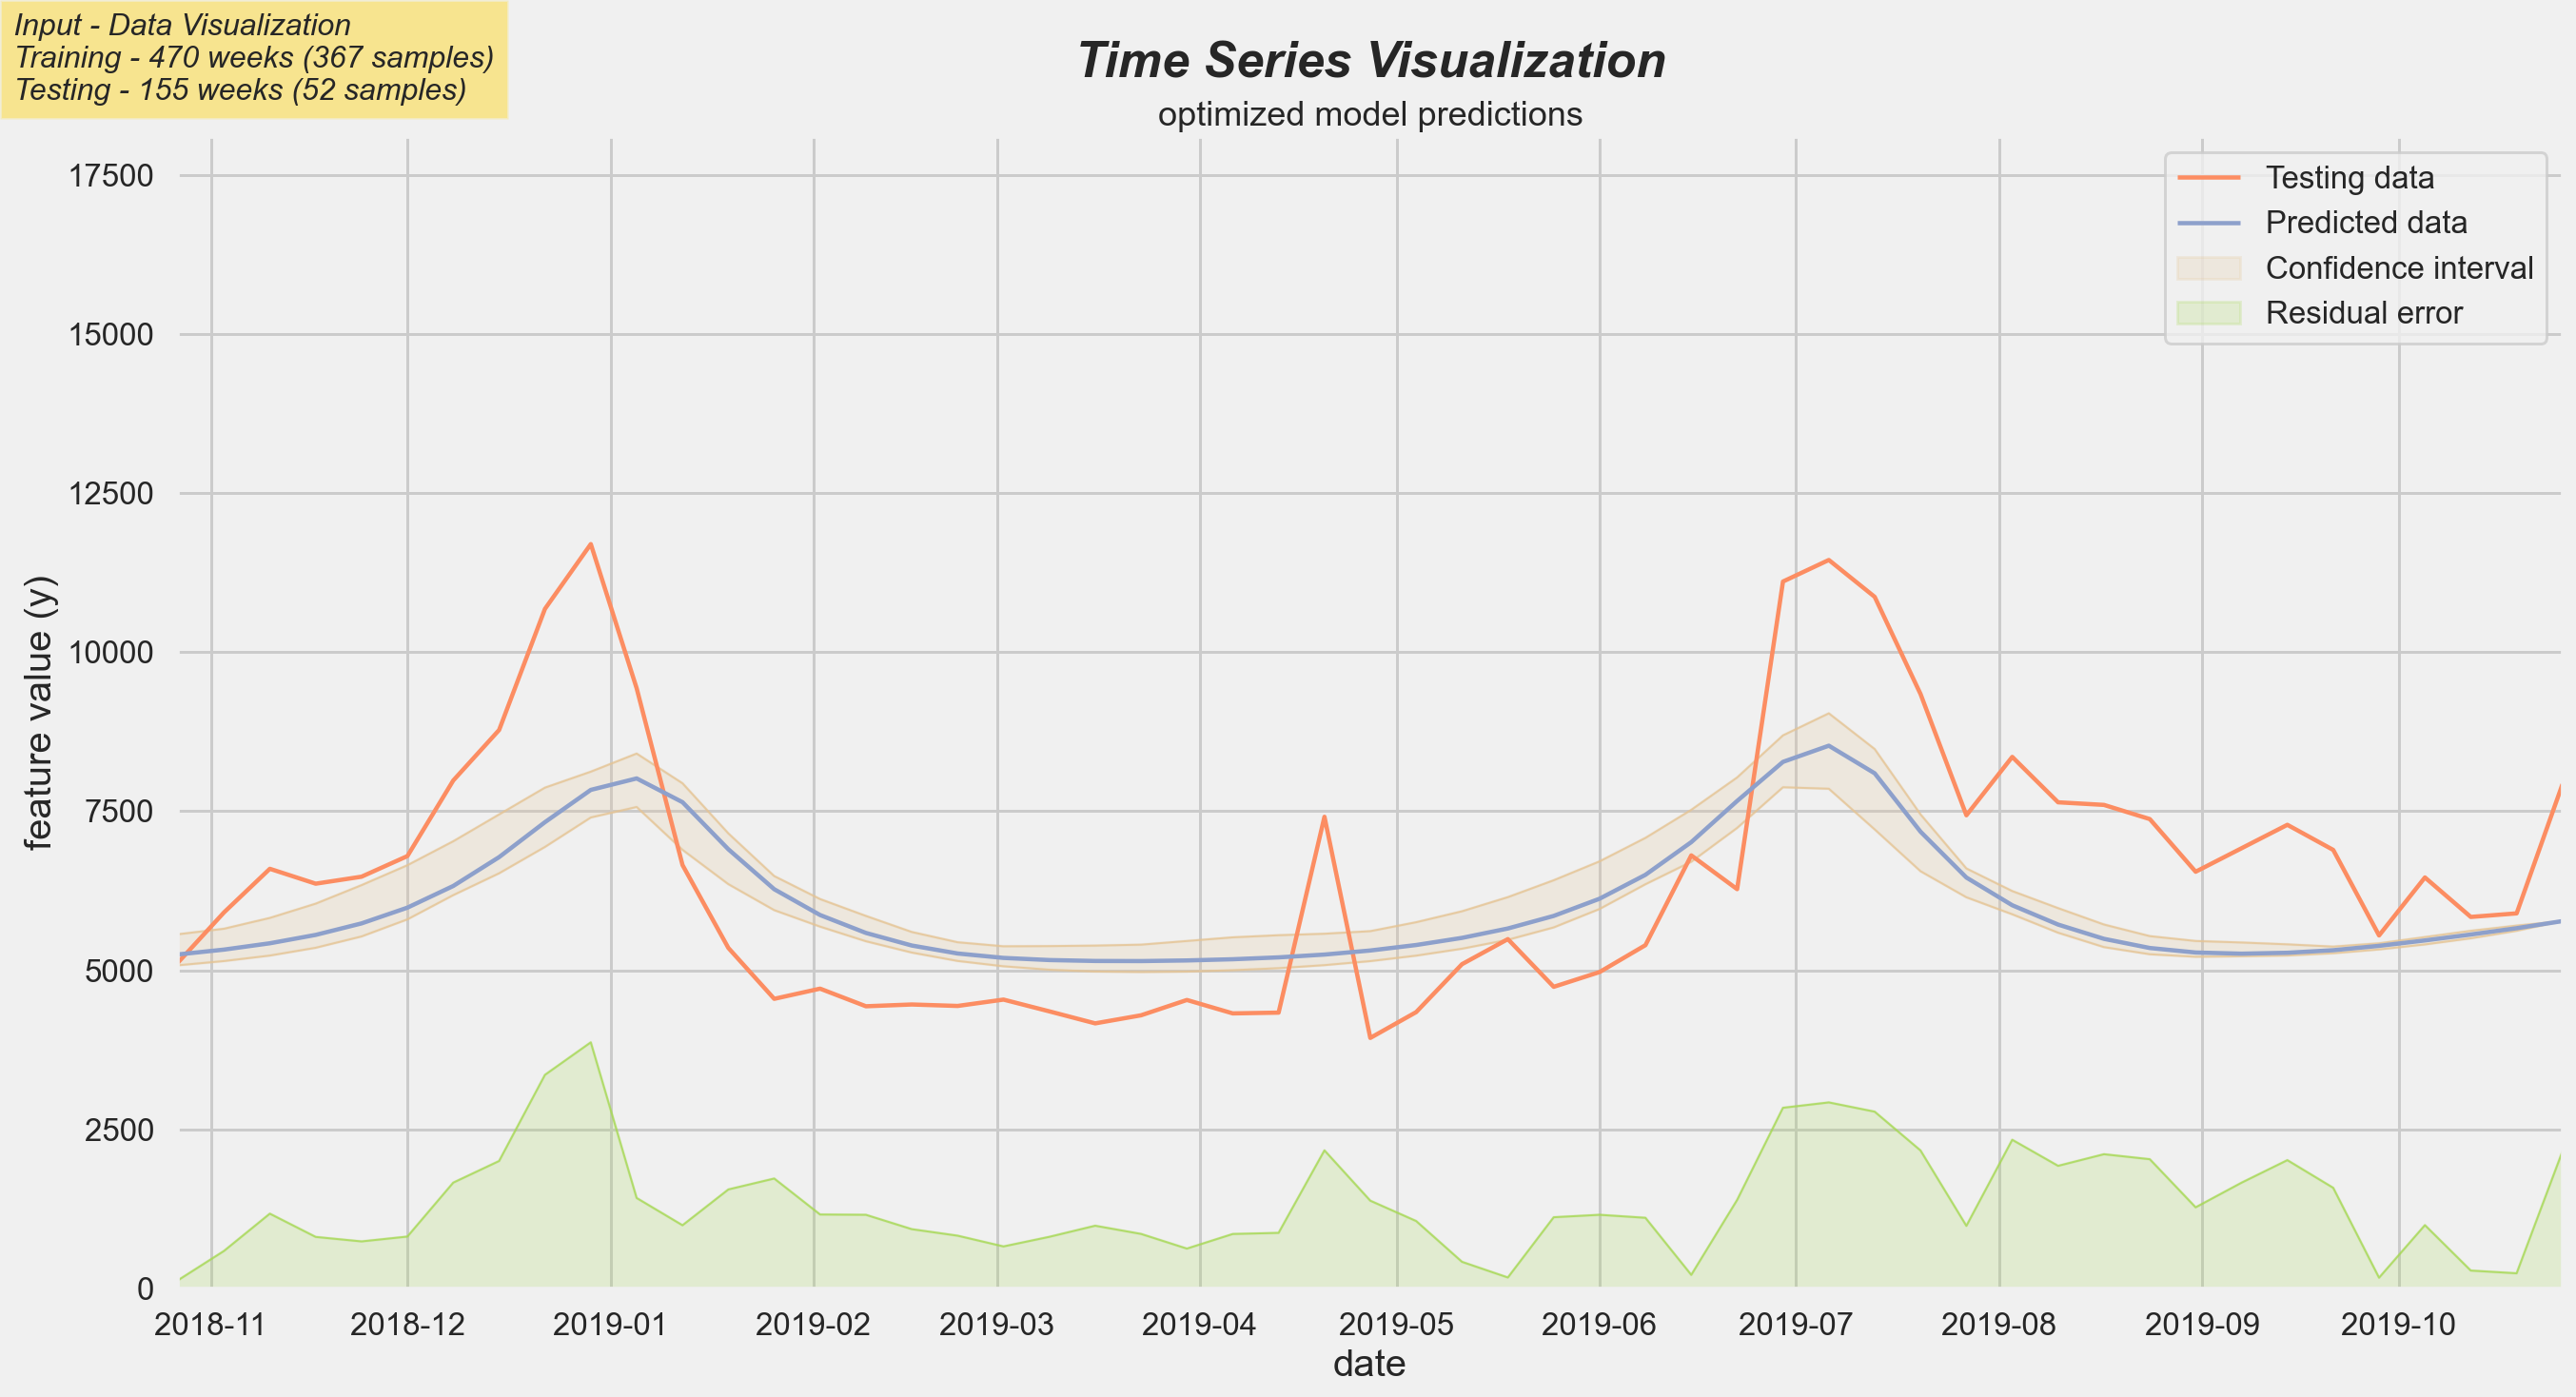

In [79]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='optimized model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    testing=df_test,
    confidence=pred_optimized['df'],
    confidence_label='Confidence interval',
    prediction=pred_optimized['df'],
    prediction_col='yhat',
    residual=pred_optimized['df'],
    residual_label='Residual error',
    ylabel='feature value (y)',
    window_size=get_n_weeks_window(4*params['output_size']))

We can **compare** both models by zooming in on the last time window, corresponding to the last year of data.

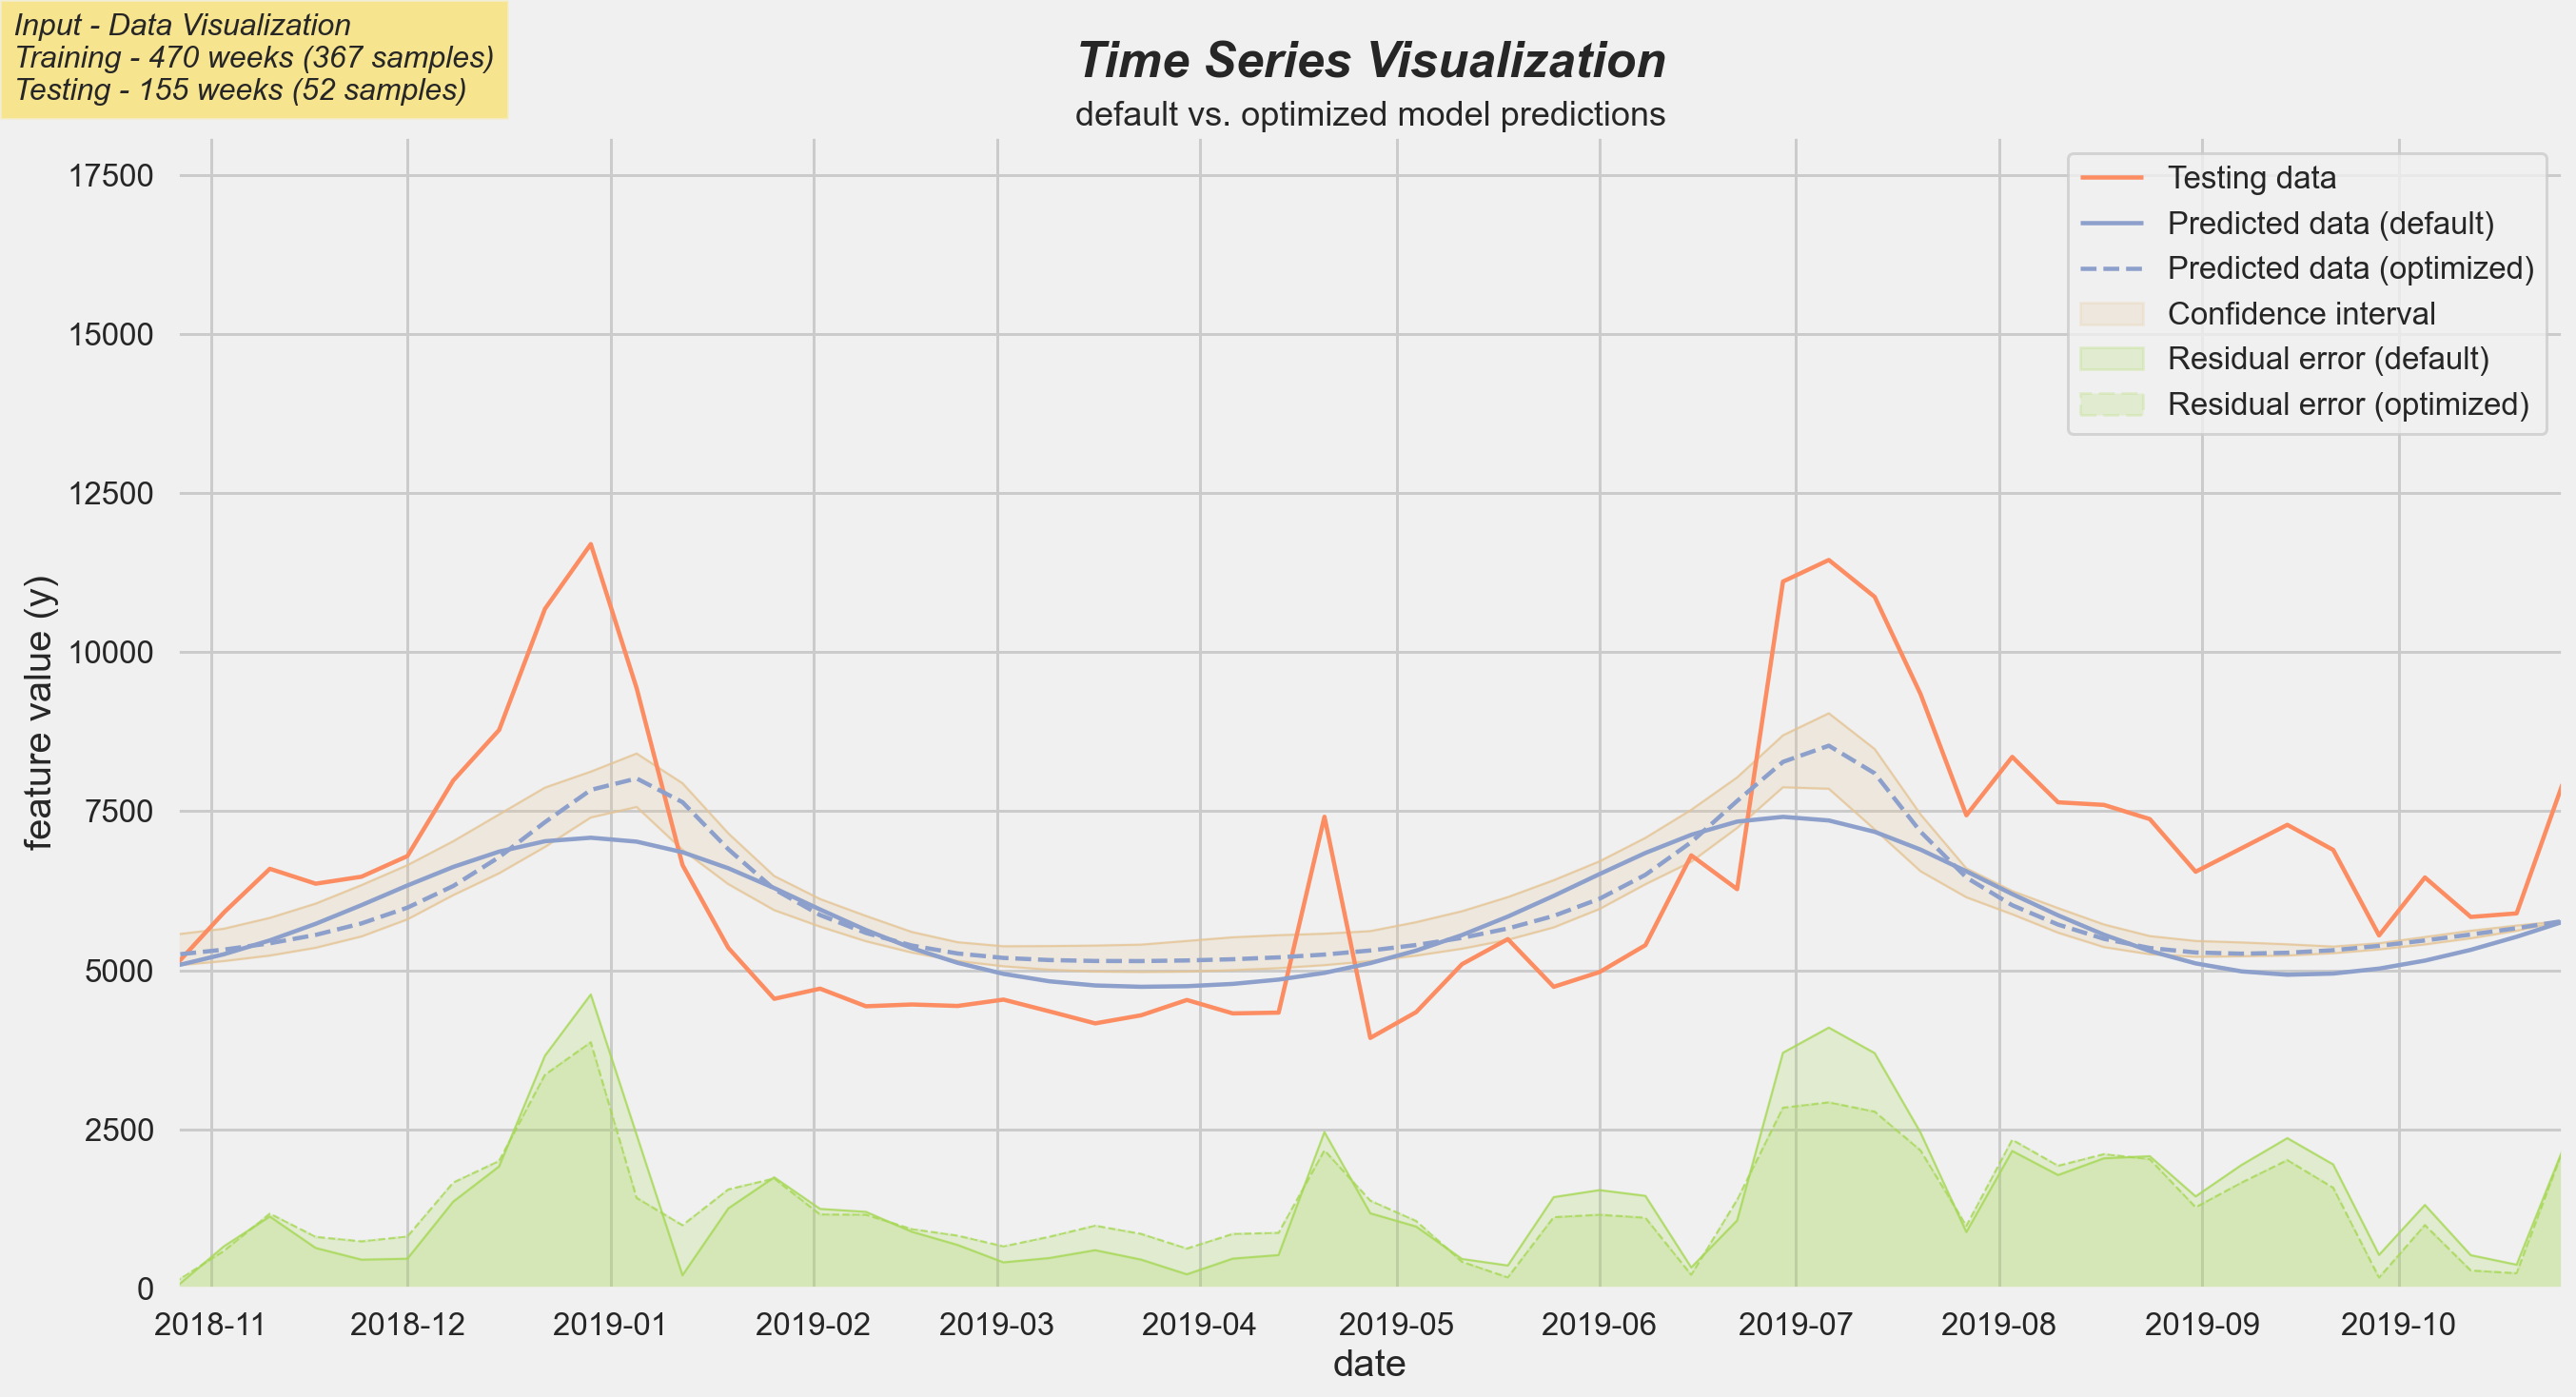

In [78]:
mwvh.plot_time_series(
    title='Time Series Visualization',
    subtitle='default vs. optimized model predictions',
    name=('Input - Data Visualization{0}' + 
          'Training - {1} weeks ({2} samples){0}' +
          'Testing - {3} weeks ({4} samples)').format(
            '\n',
             df_train.shape[0], 
             X_train.shape[0],
             df_test.shape[0],
             X_test.shape[0]),
    testing=df_test,
    confidence=pred_optimized['df'],
    confidence_label='Confidence interval',
    prediction=[pred_default['df'], pred_optimized['df']],
    prediction_label=['Predicted data (default)', 'Predicted data (optimized)'],
    residual=[pred_default['df'], pred_optimized['df']],
    residual_label=['Residual error (default)', 'Residual error (optimized)'],
    ylabel='feature value (y)',
    window_size=get_n_weeks_window(4*params['output_size']))